In [1]:
from tools_stance import * 
from models import *
import torch 
import pandas as pd

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


dict_cl=dict()
dict_cl[0]="support"
dict_cl[1]="denying"
dict_cl[2]="questioning"
dict_cl[3]="commenting"

#sdqc
d_lab=dict()
d_lab["support"]=0
d_lab["denying"]=1
d_lab["questioning"]=2
d_lab["commenting"]=3

path="../Datasets/CSV_Stance/"
train =pd.read_csv(path + "train_semeval_raw.csv")
val=pd.read_csv(path + "dev_semeval_raw.csv")
test=pd.read_csv(path + "test_semeval_raw.csv")

stoplist = stopwords.words("english")
puntos='!?."()[´]“<>¡¿-/;:=_”@#.'

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


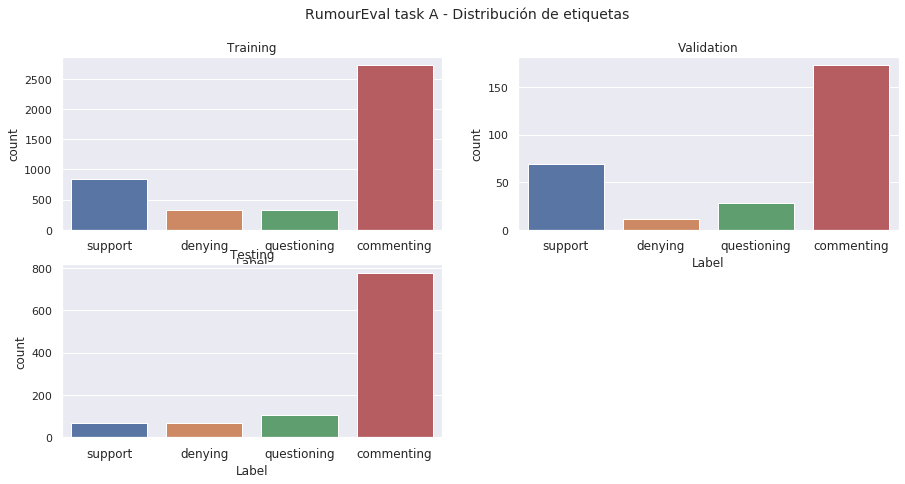

In [2]:
import seaborn as sns
sns.set(font_scale=1)
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,7))
j=220
labs=['support', 'denying', 'questioning', 'commenting']
data=[train['Label'], val['Label'], test["Label"]]
name=["Training", "Validation", "Testing"]
for i in range(3):
    j+=1
    h=fig.add_subplot(j)
    ax= sns.countplot(data[i], order=labs)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    h.title.set_text(str(name[i]))

fig.suptitle("RumourEval task A - Distribución de etiquetas", fontsize=14)
plt.show()

In [3]:
def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq, trainPredict))
    print ("")
    print ("------ Training ------")
    print ("Accuracy", name_model, ":",acc)  
    print ("F1-score None", name_model, ":",f1)
    print ("F1-score macro", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq_v, trainPredict))
    print ("")
    print ("------ Validation ------")
    print ("Accuracy", name_model, ":",acc)  
    print ("F1-score None", name_model, ":",f1)
    print ("F1-score macro", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=normalize(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("------ Testing ------")
    print ("Accuracy", name_model, ":",acc_t)  
    print ("F1-score None", name_model, ":",f1_t)
    print ("F1-score macro", name_model, ":",f1_ma_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

def cleaner(post): 
    s= re.sub(r"http\S+", " html ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " hashtag ", s) ########3
    s= re.sub(r'@\w+ ?', " user ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " number ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " number ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=token_2_idx[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in token_2_idx.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in token_2_idx.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl

In [4]:
import os 
embeddings_index = {}
token_2_idx={}
idx_2_token={}
f = open(os.path.join("../Datasets/glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
i=0
for line in f:
    values = line.split()
    if len(values)>200:
        word = values[0]
    else:
        #print ("Problema con line ", line)
        continue
    token_2_idx[word]=i
    idx_2_token[i]=word
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    i+=1
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))

Se encontraron 1193513 terminos con sus vectores de embedding.


In [5]:
MAX_LEN = 37
emb=200
EMB_matrix=np.zeros((len(token_2_idx.keys()), emb))
for i in range(len(token_2_idx.keys())):
    EMB_matrix[i]=embeddings_index[idx_2_token[i]]
    
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
EMB_matrix.shape

(1193513, 200)

In [6]:
ids_train=train['Tw_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
#class_weights= [1.0, 1.0, 1.0, 1.0]
class_weights=np.asarray(class_weights)
print ("Pesos de clases:", class_weights)

ids_val=val['Tw_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

ids_test=test['Tw_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

Pesos de clases: [1.25980975 3.18168168 3.21060606 0.38752743]


In [7]:
sentences = tws_train
n_labels = np.asarray(labels_train)
y_train=to_categorical(n_labels,num_classes=4)

sentences_val = tws_val
n_labels_val = np.array(labels_val)
y_val=to_categorical(n_labels_val,num_classes=4)

sentences_test = tws_test
n_labels_test = np.array(labels_test)
y_test=to_categorical(n_labels_test,num_classes=4)

In [8]:
input_ids=[]
for sent in sentences:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent) 
    
input_ids_val=[]
for sent in sentences_val:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_val.append(encoded_sent) 

input_ids_test=[]
for sent in sentences_test:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_test.append(encoded_sent) 
    

In [9]:
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")

shape=np.asarray(input_ids).shape
shape_val=np.asarray(input_ids_val).shape
shape_test=np.asarray(input_ids_test).shape

In [10]:
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1
    
x_val=np.zeros((shape_val[0], shape_val[1], emb))
i=0
for in_id in input_ids_val:
    x_val[i]=EMB_matrix[in_id]
    i+=1
    
x_test=np.zeros((shape_test[0], shape_test[1], emb))
i=0
for in_id in input_ids_test:
    x_test[i]=EMB_matrix[in_id]
    i+=1

In [11]:
x_train.shape

(4238, 37, 200)

In [12]:
x_test.shape

(1021, 37, 200)

## Original - No aumento


Entrenando exec  1 






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


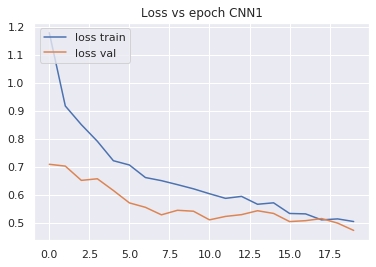

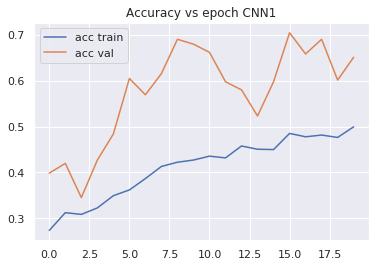


------ Training ------
Accuracy cnn1 : 0.653610193487494
F1-score None cnn1 : [0.58218319 0.4628821  0.57860465 0.72909425]
F1-score macro cnn1 : 0.5881910472343388

------ Validation ------
Accuracy cnn1 : 0.6512455516014235
F1-score None cnn1 : [0.58992806 0.30769231 0.6        0.73684211]
F1-score macro cnn1 : 0.5586156176273556

------ Testing ------
Accuracy cnn1 : 0.6023506366307542
F1-score None cnn1 : [0.125      0.23275862 0.53797468 0.72474378]
F1-score macro cnn1 : 0.4051192704215937


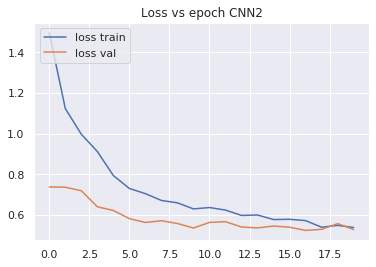

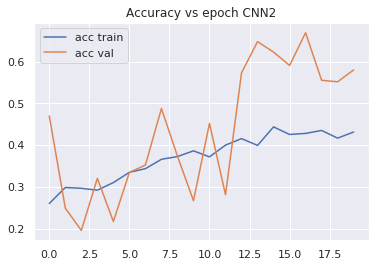


------ Training ------
Accuracy cnn2 : 0.5422369042000944
F1-score None cnn2 : [0.58231293 0.33504274 0.44460127 0.61507128]
F1-score macro cnn2 : 0.4942570533994674

------ Validation ------
Accuracy cnn2 : 0.5800711743772242
F1-score None cnn2 : [0.57575758 0.13333333 0.52631579 0.66896552]
F1-score macro cnn2 : 0.47609305395149315

------ Testing ------
Accuracy cnn2 : 0.49951028403525954
F1-score None cnn2 : [0.11570248 0.2        0.45255474 0.62113821]
F1-score macro cnn2 : 0.347348858811626


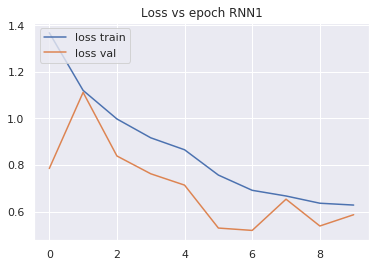

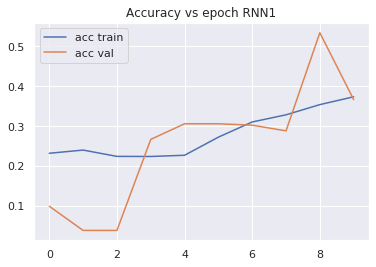


------ Training ------
Accuracy rnn1 : 0.32468145351580935
F1-score None rnn1 : [0.55267703 0.17094017 0.25777041 0.2979351 ]
F1-score macro rnn1 : 0.3198306784559096

------ Validation ------
Accuracy rnn1 : 0.3665480427046263
F1-score None rnn1 : [0.56756757 0.         0.32298137 0.3196347 ]
F1-score macro rnn1 : 0.3025459093058855

------ Testing ------
Accuracy rnn1 : 0.25857002938295787
F1-score None rnn1 : [0.2        0.15447154 0.29640719 0.27155172]
F1-score macro rnn1 : 0.23060761362053017


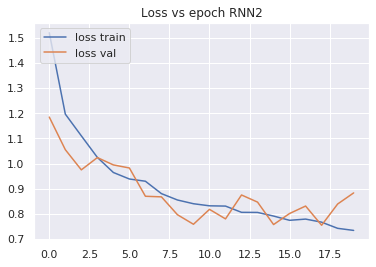

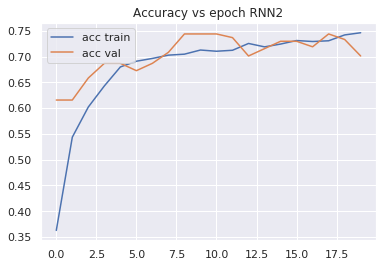


------ Training ------
Accuracy rnn2 : 0.6939594148183105
F1-score None rnn2 : [0.55364455 0.08602151 0.46511628 0.81246698]
F1-score macro rnn2 : 0.4793123304286357

------ Validation ------
Accuracy rnn2 : 0.701067615658363
F1-score None rnn2 : [0.52252252 0.16666667 0.62337662 0.79005525]
F1-score macro rnn2 : 0.5256552652961493

------ Testing ------
Accuracy rnn2 : 0.702252693437806
F1-score None rnn2 : [0.05128205 0.12345679 0.46242775 0.81977879]
F1-score macro rnn2 : 0.3642363442301515


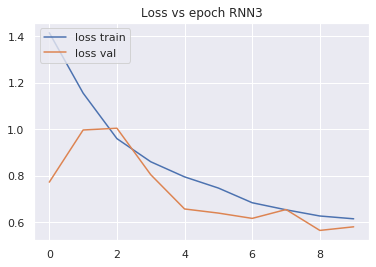

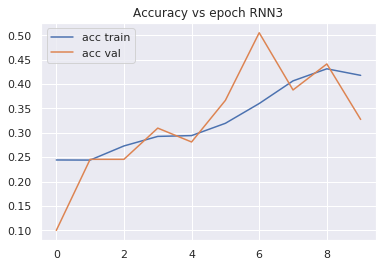


------ Training ------
Accuracy rnn3 : 0.2888154789995281
F1-score None rnn3 : [0.37842997 0.01173021 0.4874477  0.13119143]
F1-score macro rnn3 : 0.252199826350191

------ Validation ------
Accuracy rnn3 : 0.3274021352313167
F1-score None rnn3 : [0.41471572 0.         0.70422535 0.05524862]
F1-score macro rnn3 : 0.29354742249018795

------ Testing ------
Accuracy rnn3 : 0.1939275220372184
F1-score None rnn3 : [0.14165666 0.         0.5862069  0.12735849]
F1-score macro rnn3 : 0.213805512445707

Entrenando exec  2 



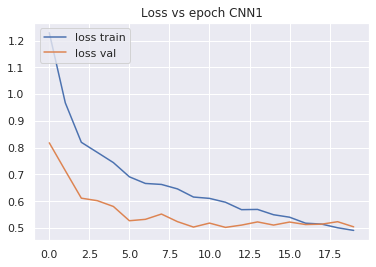

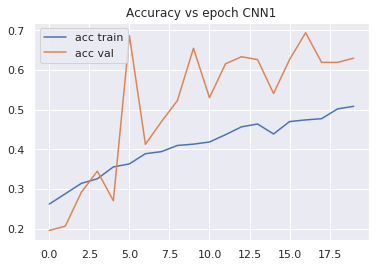


------ Training ------
Accuracy cnn1 : 0.6304860783388391
F1-score None cnn1 : [0.58237548 0.40510638 0.63851699 0.70025189]
F1-score macro cnn1 : 0.5815626859664074

------ Validation ------
Accuracy cnn1 : 0.6298932384341637
F1-score None cnn1 : [0.53731343 0.28571429 0.64705882 0.72025723]
F1-score macro cnn1 : 0.5475859442015516

------ Testing ------
Accuracy cnn1 : 0.5905974534769833
F1-score None cnn1 : [0.11666667 0.22291022 0.6119403  0.71825695]
F1-score macro cnn1 : 0.41744353288857605


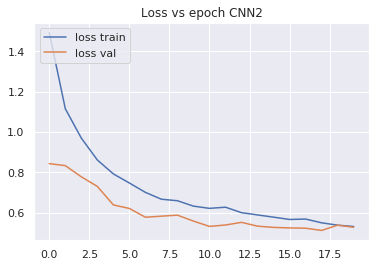

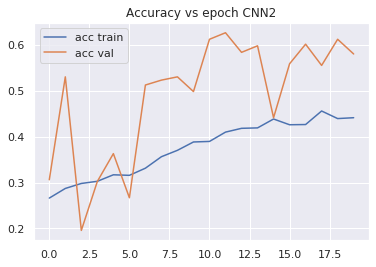


------ Training ------
Accuracy cnn2 : 0.5792826805096744
F1-score None cnn2 : [0.59030303 0.38383838 0.46372688 0.64959152]
F1-score macro cnn2 : 0.5218649550570156

------ Validation ------
Accuracy cnn2 : 0.5800711743772242
F1-score None cnn2 : [0.58992806 0.15384615 0.52631579 0.65051903]
F1-score macro cnn2 : 0.4801522580039158

------ Testing ------
Accuracy cnn2 : 0.5416258570029383
F1-score None cnn2 : [0.21192053 0.23931624 0.46268657 0.66294821]
F1-score macro cnn2 : 0.3942178858632644


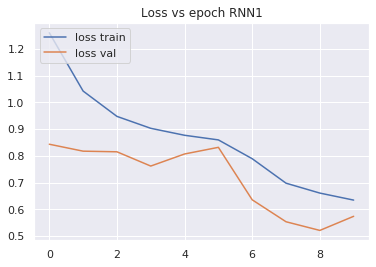

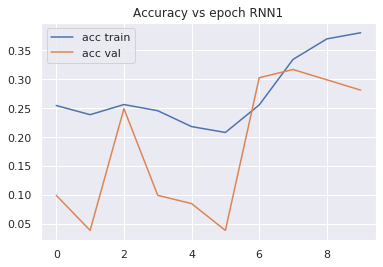


------ Training ------
Accuracy rnn1 : 0.24775837659273242
F1-score None rnn1 : [0.55210918 0.16659927 0.35967302 0.09237085]
F1-score macro rnn1 : 0.29268808241705624

------ Validation ------
Accuracy rnn1 : 0.28113879003558717
F1-score None rnn1 : [0.57746479 0.032      0.48598131 0.10638298]
F1-score macro rnn1 : 0.3004572689667534

------ Testing ------
Accuracy rnn1 : 0.1929480901077375
F1-score None rnn1 : [0.18079096 0.17418351 0.46943765 0.07134071]
F1-score macro rnn1 : 0.22393821036133552


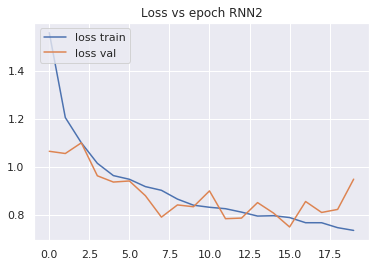

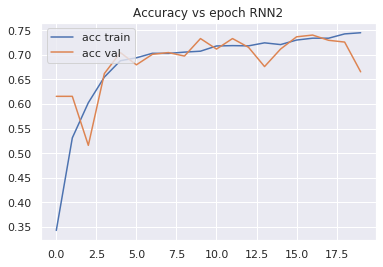


------ Training ------
Accuracy rnn2 : 0.7180273714016046
F1-score None rnn2 : [0.65629053 0.25401929 0.54739336 0.81455743]
F1-score macro rnn2 : 0.5680651535821533

------ Validation ------
Accuracy rnn2 : 0.6654804270462633
F1-score None rnn2 : [0.62068966 0.15384615 0.52307692 0.75460123]
F1-score macro rnn2 : 0.5130534897723389

------ Testing ------
Accuracy rnn2 : 0.6356513222331048
F1-score None rnn2 : [0.2208589  0.13095238 0.47389558 0.76744186]
F1-score macro rnn2 : 0.398287179863084


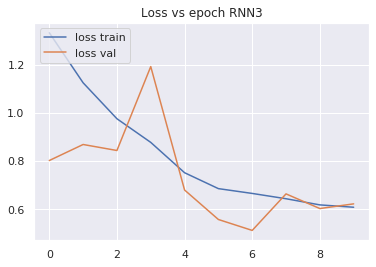

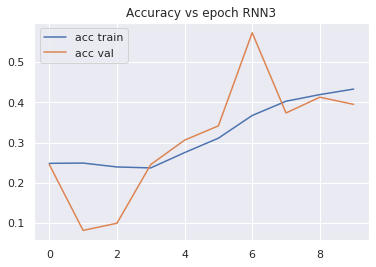


------ Training ------
Accuracy rnn3 : 0.3473336479471449
F1-score None rnn3 : [0.55916616 0.12947977 0.25844102 0.36302709]
F1-score macro rnn3 : 0.3275285072537534

------ Validation ------
Accuracy rnn3 : 0.39501779359430605
F1-score None rnn3 : [0.57534247 0.         0.32911392 0.37554585]
F1-score macro rnn3 : 0.3200005603331105

------ Testing ------
Accuracy rnn3 : 0.31047992164544563
F1-score None rnn3 : [0.24390244 0.14814815 0.28328612 0.3723296 ]
F1-score macro rnn3 : 0.26191657735201224

Entrenando exec  3 



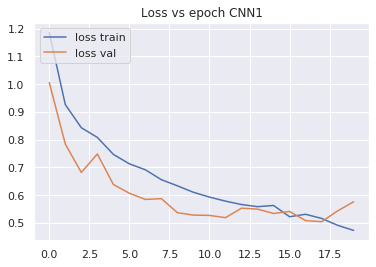

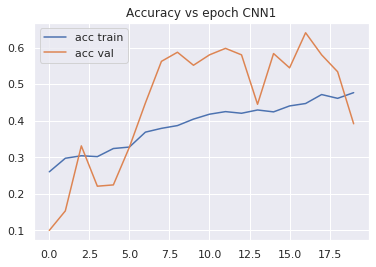


------ Training ------
Accuracy cnn1 : 0.39570552147239263
F1-score None cnn1 : [0.58293515 0.2748538  0.44413602 0.36839113]
F1-score macro cnn1 : 0.41757902568323135

------ Validation ------
Accuracy cnn1 : 0.3914590747330961
F1-score None cnn1 : [0.528      0.09009009 0.4950495  0.41777778]
F1-score macro cnn1 : 0.38272934320459073

------ Testing ------
Accuracy cnn1 : 0.3006856023506366
F1-score None cnn1 : [0.11428571 0.17770035 0.46568627 0.32460733]
F1-score macro cnn1 : 0.2705699167676265


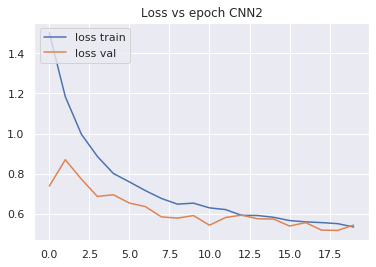

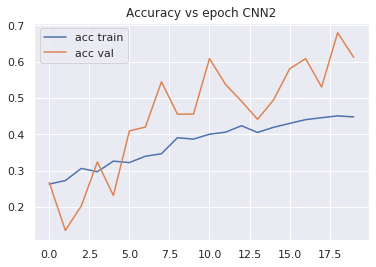


------ Training ------
Accuracy cnn2 : 0.5792826805096744
F1-score None cnn2 : [0.55664336 0.34429066 0.49310624 0.66738244]
F1-score macro cnn2 : 0.5153556735144713

------ Validation ------
Accuracy cnn2 : 0.6120996441281139
F1-score None cnn2 : [0.57142857 0.17021277 0.56818182 0.71096346]
F1-score macro cnn2 : 0.5051966526793346

------ Testing ------
Accuracy cnn2 : 0.5475024485798237
F1-score None cnn2 : [0.09708738 0.2027027  0.51540616 0.6718507 ]
F1-score macro cnn2 : 0.37176173591323614


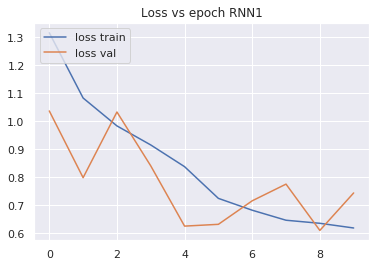

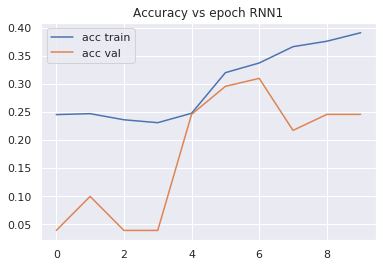


------ Training ------
Accuracy rnn1 : 0.2104766399244927
F1-score None rnn1 : [0.55807744 0.05168986 0.18366197 0.09230769]
F1-score macro rnn1 : 0.22143424038894444

------ Validation ------
Accuracy rnn1 : 0.24555160142348753
F1-score None rnn1 : [0.54814815 0.         0.23893805 0.05464481]
F1-score macro rnn1 : 0.21043275249716564

------ Testing ------
Accuracy rnn1 : 0.14397649363369247
F1-score None rnn1 : [0.14634146 0.02040816 0.20682731 0.08242424]
F1-score macro rnn1 : 0.11400029458528262


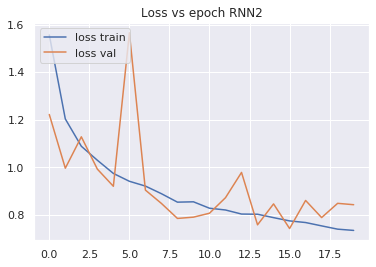

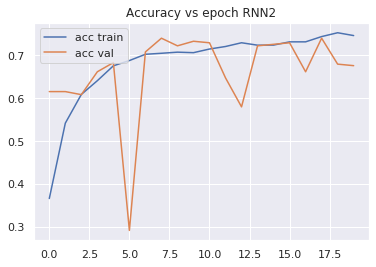


------ Training ------
Accuracy rnn2 : 0.7491741387446909
F1-score None rnn2 : [0.6595144  0.13881748 0.62883436 0.83298023]
F1-score macro rnn2 : 0.5650366152953873

------ Validation ------
Accuracy rnn2 : 0.6761565836298933
F1-score None rnn2 : [0.58598726 0.         0.57142857 0.76190476]
F1-score macro rnn2 : 0.4798301486199575

------ Testing ------
Accuracy rnn2 : 0.7140058765915769
F1-score None rnn2 : [0.24731183 0.04494382 0.5177665  0.83184713]
F1-score macro rnn2 : 0.41046731985039975


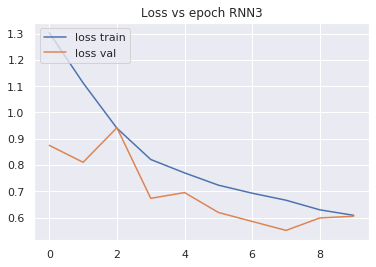

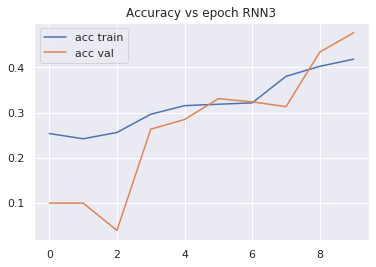


------ Training ------
Accuracy rnn3 : 0.41599811231713074
F1-score None rnn3 : [0.55899198 0.09964413 0.26751592 0.48010076]
F1-score macro rnn3 : 0.3515631972551646

------ Validation ------
Accuracy rnn3 : 0.47686832740213525
F1-score None rnn3 : [0.6        0.         0.36363636 0.5060241 ]
F1-score macro rnn3 : 0.3674151150054764

------ Testing ------
Accuracy rnn3 : 0.38491674828599415
F1-score None rnn3 : [0.23404255 0.11382114 0.30769231 0.48843663]
F1-score macro rnn3 : 0.2859981579606588

Entrenando exec  4 



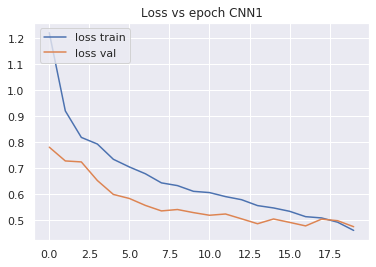

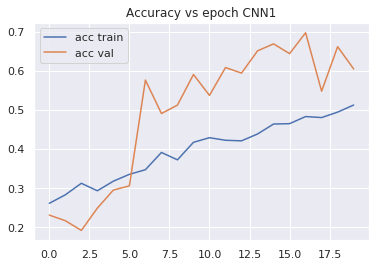


------ Training ------
Accuracy cnn1 : 0.6323737612081171
F1-score None cnn1 : [0.60223464 0.44214162 0.66243386 0.68601353]
F1-score macro cnn1 : 0.5982059127626862

------ Validation ------
Accuracy cnn1 : 0.604982206405694
F1-score None cnn1 : [0.56774194 0.17777778 0.64788732 0.68041237]
F1-score macro cnn1 : 0.5184548520848328

------ Testing ------
Accuracy cnn1 : 0.555337904015671
F1-score None cnn1 : [0.29189189 0.22492401 0.58426966 0.6740682 ]
F1-score macro cnn1 : 0.44378844170317255


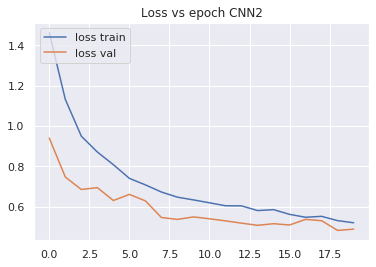

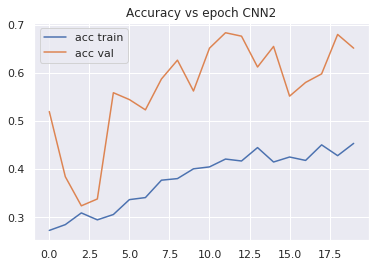


------ Training ------
Accuracy cnn2 : 0.6396885323265691
F1-score None cnn2 : [0.58018253 0.3577431  0.56117755 0.72162485]
F1-score macro cnn2 : 0.55518200753224

------ Validation ------
Accuracy cnn2 : 0.6512455516014235
F1-score None cnn2 : [0.5942029  0.17142857 0.64788732 0.72955975]
F1-score macro cnn2 : 0.5357696355876578

------ Testing ------
Accuracy cnn2 : 0.6150832517140059
F1-score None cnn2 : [0.1147541  0.20627803 0.53374233 0.74544128]
F1-score macro cnn2 : 0.40005393507233233


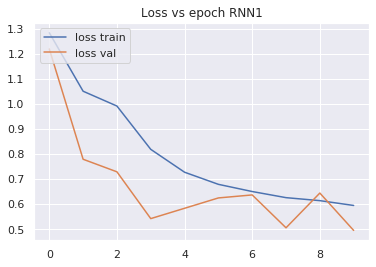

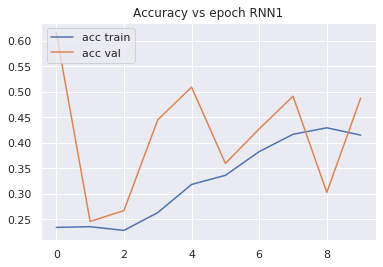


------ Training ------
Accuracy rnn1 : 0.4601226993865031
F1-score None rnn1 : [0.46451133 0.17868676 0.51327434 0.51119311]
F1-score macro rnn1 : 0.4169163855619499

------ Validation ------
Accuracy rnn1 : 0.4875444839857651
F1-score None rnn1 : [0.5046729  0.15384615 0.65714286 0.47698745]
F1-score macro rnn1 : 0.4481623389710044

------ Testing ------
Accuracy rnn1 : 0.40744368266405484
F1-score None rnn1 : [0.16708861 0.13571429 0.65271967 0.5070922 ]
F1-score macro rnn1 : 0.3656536892906873


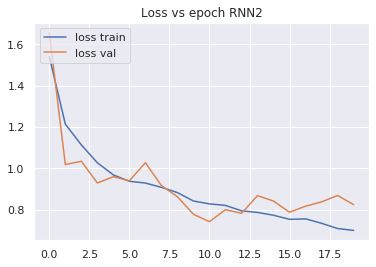

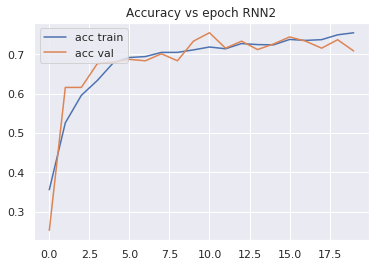


------ Training ------
Accuracy rnn2 : 0.7730061349693251
F1-score None rnn2 : [0.65416667 0.28701595 0.65047233 0.85416667]
F1-score macro rnn2 : 0.6114554033366226

------ Validation ------
Accuracy rnn2 : 0.708185053380783
F1-score None rnn2 : [0.56692913 0.26666667 0.6440678  0.7867036 ]
F1-score macro rnn2 : 0.5660917995607843

------ Testing ------
Accuracy rnn2 : 0.7091087169441724
F1-score None rnn2 : [0.11111111 0.10752688 0.55357143 0.82099937]
F1-score macro rnn2 : 0.3983021972229752


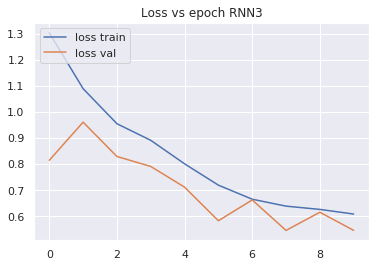

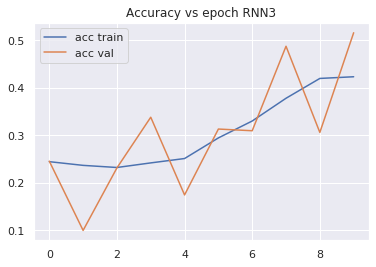


------ Training ------
Accuracy rnn3 : 0.4738084001887683
F1-score None rnn3 : [0.53912111 0.16347124 0.37864769 0.54959658]
F1-score macro rnn3 : 0.4077091563765662

------ Validation ------
Accuracy rnn3 : 0.5160142348754448
F1-score None rnn3 : [0.53571429 0.         0.53608247 0.56273764]
F1-score macro rnn3 : 0.40863360063166027

------ Testing ------
Accuracy rnn3 : 0.43290891283055827
F1-score None rnn3 : [0.16740088 0.19762846 0.43925234 0.5361552 ]
F1-score macro rnn3 : 0.33510921970644003

Entrenando exec  5 



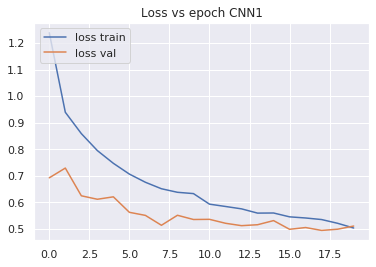

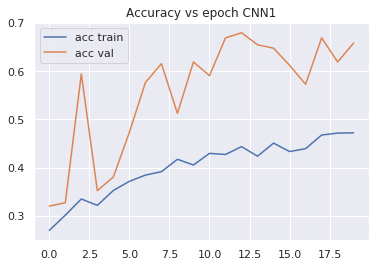


------ Training ------
Accuracy cnn1 : 0.6387446908919302
F1-score None cnn1 : [0.58815959 0.388      0.60079051 0.71364562]
F1-score macro cnn1 : 0.5726489307937108

------ Validation ------
Accuracy cnn1 : 0.6583629893238434
F1-score None cnn1 : [0.56934307 0.23529412 0.66666667 0.73981191]
F1-score macro cnn1 : 0.5527789405582153

------ Testing ------
Accuracy cnn1 : 0.6023506366307542
F1-score None cnn1 : [0.10169492 0.20477816 0.58394161 0.73544584]
F1-score macro cnn1 : 0.40646512862351813


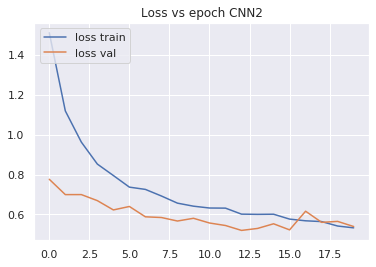

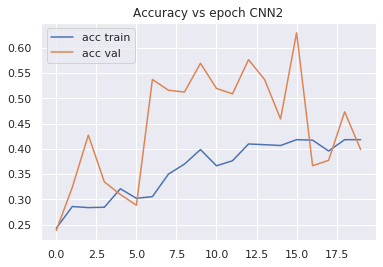


------ Training ------
Accuracy cnn2 : 0.4110429447852761
F1-score None cnn2 : [0.57823129 0.23727273 0.54864154 0.40545703]
F1-score macro cnn2 : 0.44240064705429516

------ Validation ------
Accuracy cnn2 : 0.398576512455516
F1-score None cnn2 : [0.546875   0.09677419 0.65789474 0.39316239]
F1-score macro cnn2 : 0.42367658088822135

------ Testing ------
Accuracy cnn2 : 0.3379040156709109
F1-score None cnn2 : [0.12068966 0.1858864  0.50609756 0.39528024]
F1-score macro cnn2 : 0.3019884637225242


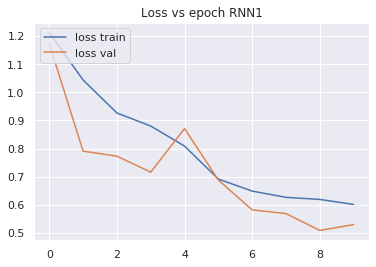

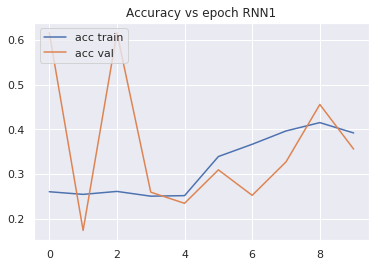


------ Training ------
Accuracy rnn1 : 0.30863614912694665
F1-score None rnn1 : [0.50403587 0.17647059 0.39166046 0.20826759]
F1-score macro rnn1 : 0.3201086291570455

------ Validation ------
Accuracy rnn1 : 0.35587188612099646
F1-score None rnn1 : [0.54255319 0.07228916 0.55319149 0.20304569]
F1-score macro rnn1 : 0.3427698806891894

------ Testing ------
Accuracy rnn1 : 0.23996082272282077
F1-score None rnn1 : [0.1704918  0.17429194 0.45273632 0.20091324]
F1-score macro rnn1 : 0.24960832567340063


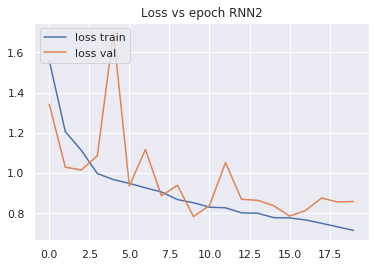

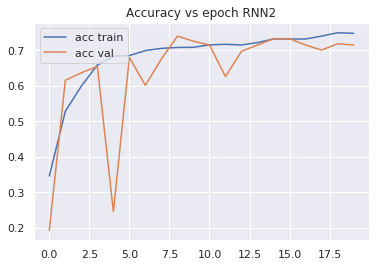


------ Training ------
Accuracy rnn2 : 0.766635205285512
F1-score None rnn2 : [0.66043165 0.30111524 0.63989637 0.85249307]
F1-score macro rnn2 : 0.6134840860402964

------ Validation ------
Accuracy rnn2 : 0.7153024911032029
F1-score None rnn2 : [0.57142857 0.2        0.5862069  0.8109589 ]
F1-score macro rnn2 : 0.5421485930224712

------ Testing ------
Accuracy rnn2 : 0.702252693437806
F1-score None rnn2 : [0.20967742 0.144      0.47161572 0.81969309]
F1-score macro rnn2 : 0.411246558627003


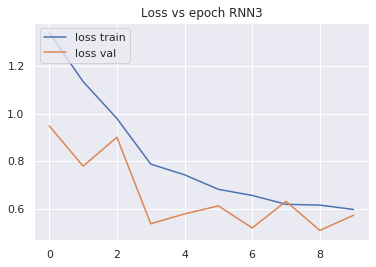

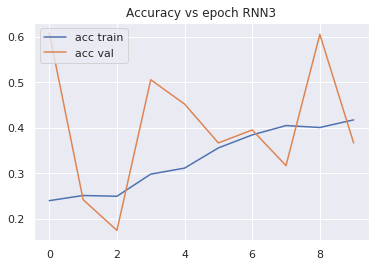


------ Training ------
Accuracy rnn3 : 0.3154789995280793
F1-score None rnn3 : [0.43768023 0.03252033 0.32696629 0.22270742]
F1-score macro rnn3 : 0.2549685679035399

------ Validation ------
Accuracy rnn3 : 0.3665480427046263
F1-score None rnn3 : [0.48101266 0.         0.44067797 0.20408163]
F1-score macro rnn3 : 0.281443064245651

------ Testing ------
Accuracy rnn3 : 0.24877571008814886
F1-score None rnn3 : [0.16764133 0.07228916 0.3575419  0.24642464]
F1-score macro rnn3 : 0.2109742560170389


In [13]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=20, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn1_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=20, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=10, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn1_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=20, BS=32, verb=0, focal=False)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=10, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn3_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [14]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("Original - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("Original - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("Original - Accuracy promedio para",key,":" ,temp/5)

Original - F1-score promedio para cnn1 : [0.14990784 0.21261427 0.55676251 0.63542442]
Original - F1-score promedio para cnn2 : [0.13203083 0.20683667 0.49409747 0.61933173]
Original - F1-score promedio para rnn1 : [0.17294257 0.13181389 0.41562563 0.22666442]
Original - F1-score promedio para rnn2 : [0.16804826 0.11017597 0.49585539 0.81195205]
Original - F1-score promedio para rnn3 : [0.19092877 0.10637738 0.39479591 0.35414091]

Original - F1-score macro promedio para cnn1 : 0.38867725808089737 desvest:  0.060664377202607346
Original - F1-score macro promedio para cnn2 : 0.3630741758765966 desvest:  0.035753760046916834
Original - F1-score macro promedio para rnn1 : 0.23676162670624726 desvest:  0.08006354728533052
Original - F1-score macro promedio para rnn2 : 0.3965079199587227 desvest:  0.017087610200628215
Original - F1-score macro promedio para rnn3 : 0.26156074469637136 desvest:  0.04657520156575645

Original - Accuracy promedio para cnn1 : 0.5302644466209598
Original - Accura

In [15]:
------ BERT 

for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("Original - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("Original - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("Original - Accuracy promedio para",key,":" ,temp/5)

Original - F1-score promedio para cnn1 : [0.16528772 0.1760289  0.55286017 0.69199626]
Original - F1-score promedio para cnn2 : [0.17898463 0.19043556 0.58885957 0.65821372]
Original - F1-score promedio para rnn1 : [0.19421346 0.11864027 0.4160722  0.28838011]
Original - F1-score promedio para rnn2 : [0.13723781 0.05853355 0.46583954 0.75709114]
Original - F1-score promedio para rnn3 : [0.20103315 0.11623811 0.39740424 0.1675946 ]

Original - F1-score macro promedio para cnn1 : 0.39654326157138287 desvest:  0.032029553424026115
Original - F1-score macro promedio para cnn2 : 0.4041233685521603 desvest:  0.026653527248854048
Original - F1-score macro promedio para rnn1 : 0.2543265077223743 desvest:  0.07295603258199077
Original - F1-score macro promedio para rnn2 : 0.35467551120628854 desvest:  0.02032030260913774
Original - F1-score macro promedio para rnn3 : 0.22056752604345417 desvest:  0.07470157545336399

Original - Accuracy promedio para cnn1 : 0.562977473065622
Original - Accuracy

### Aumento no Ponderado - Clase

In [15]:
macro_augmented = np.load('../Datasets/CSV_Stance/balance_clase_noPon_GloVe.npy', allow_pickle=True)
np.random.shuffle(macro_augmented)

ids_train=macro_augmented[:,0]
tws_train=macro_augmented[:,1]
labels_train=macro_augmented[:,2]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
print ("Pesos de clases:", class_weights)

sentences = tws_train
n_labels = labels_train.copy()

input_ids = []
for sent in sentences:
    encoded_sent = [] 
    for wd in sent:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
y_train=to_categorical(n_labels,num_classes=4)
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1

Pesos de clases: [1. 1. 1. 1.]



Entrenando exec  1 



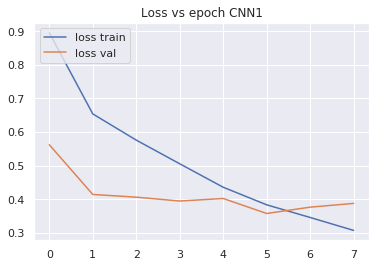

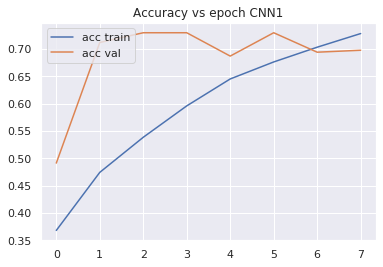


------ Training ------
Accuracy cnn1 : 0.846104608632041
F1-score None cnn1 : [0.79420179 0.91137814 0.94388849 0.73698966]
F1-score macro cnn1 : 0.8466145228536617

------ Validation ------
Accuracy cnn1 : 0.697508896797153
F1-score None cnn1 : [0.625      0.30769231 0.63636364 0.77300613]
F1-score macro cnn1 : 0.5855155197563173

------ Testing ------
Accuracy cnn1 : 0.6679725759059746
F1-score None cnn1 : [0.20430108 0.27380952 0.609375   0.7849162 ]
F1-score macro cnn1 : 0.46810045004891476


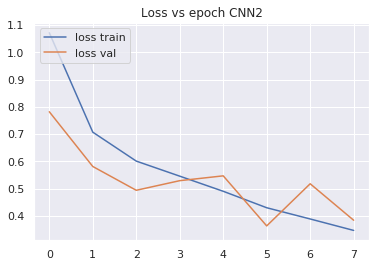

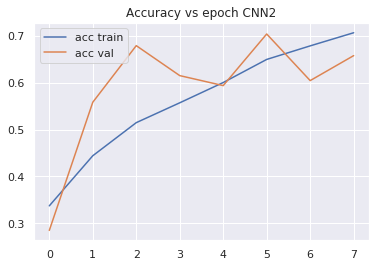


------ Training ------
Accuracy cnn2 : 0.77075713240673
F1-score None cnn2 : [0.71441086 0.80298507 0.89416486 0.67550867]
F1-score macro cnn2 : 0.7717673647665487

------ Validation ------
Accuracy cnn2 : 0.6583629893238434
F1-score None cnn2 : [0.43478261 0.4        0.57831325 0.76217765]
F1-score macro cnn2 : 0.5438183780343749

------ Testing ------
Accuracy cnn2 : 0.713026444662096
F1-score None cnn2 : [0.11111111 0.20952381 0.55483871 0.82290981]
F1-score macro cnn2 : 0.4245958598493161


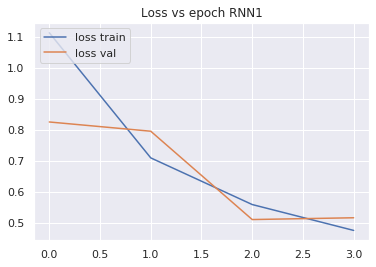

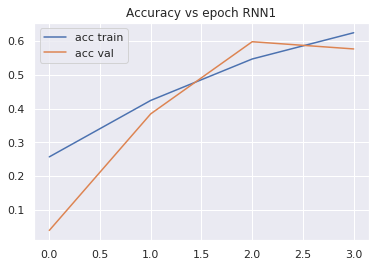


------ Training ------
Accuracy rnn1 : 0.6613935625457206
F1-score None rnn1 : [0.6768544  0.64836692 0.78462739 0.53619822]
F1-score macro rnn1 : 0.6615117314950735

------ Validation ------
Accuracy rnn1 : 0.5765124555160143
F1-score None rnn1 : [0.56626506 0.13953488 0.57971014 0.64788732]
F1-score macro rnn1 : 0.4833493532082731

------ Testing ------
Accuracy rnn1 : 0.5073457394711067
F1-score None rnn1 : [0.24888889 0.19101124 0.57831325 0.63366337]
F1-score macro rnn1 : 0.4129691860481567


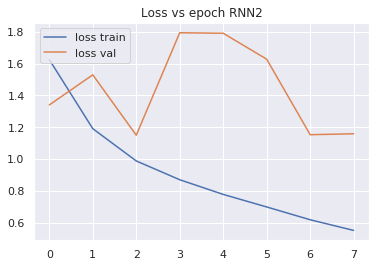

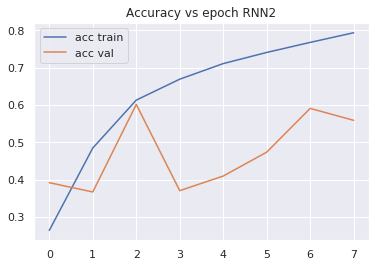


------ Training ------
Accuracy rnn2 : 0.8365032918800293
F1-score None rnn2 : [0.80198202 0.884833   0.94078827 0.71889233]
F1-score macro rnn2 : 0.8366239028825414

------ Validation ------
Accuracy rnn2 : 0.5587188612099644
F1-score None rnn2 : [0.44615385 0.17241379 0.59016393 0.67092652]
F1-score macro rnn2 : 0.46991452281385226

------ Testing ------
Accuracy rnn2 : 0.6013712047012733
F1-score None rnn2 : [0.22026432 0.21428571 0.5840708  0.73113553]
F1-score macro rnn2 : 0.4374390897655098


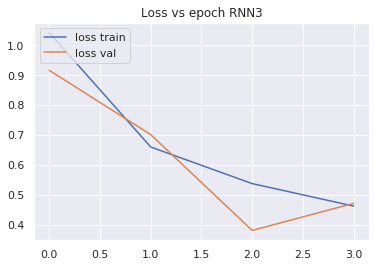

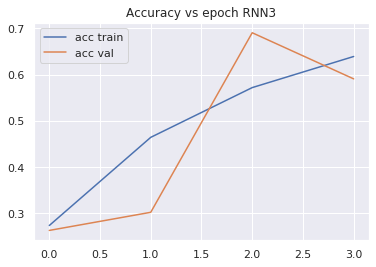


------ Training ------
Accuracy rnn3 : 0.6837966349670812
F1-score None rnn3 : [0.66417445 0.66062603 0.81121683 0.5942029 ]
F1-score macro rnn3 : 0.6825550520678195

------ Validation ------
Accuracy rnn3 : 0.5907473309608541
F1-score None rnn3 : [0.50393701 0.19047619 0.54117647 0.69480519]
F1-score macro rnn3 : 0.4825987159359091

------ Testing ------
Accuracy rnn3 : 0.5915768854064642
F1-score None rnn3 : [0.2027027  0.225      0.50793651 0.71994025]
F1-score macro rnn3 : 0.4138948661400118

Entrenando exec  2 



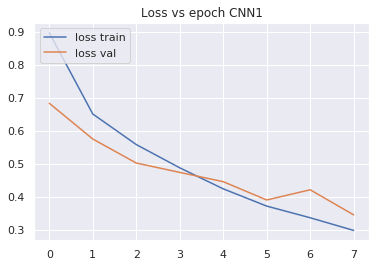

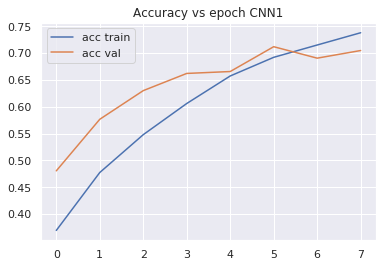


------ Training ------
Accuracy cnn1 : 0.84025237746891
F1-score None cnn1 : [0.77130977 0.90396542 0.94719885 0.74195645]
F1-score macro cnn1 : 0.8411076242289863

------ Validation ------
Accuracy cnn1 : 0.7046263345195729
F1-score None cnn1 : [0.61111111 0.38095238 0.62295082 0.7797619 ]
F1-score macro cnn1 : 0.598694054124382

------ Testing ------
Accuracy cnn1 : 0.7110675808031341
F1-score None cnn1 : [0.11864407 0.25       0.62008734 0.82422646]
F1-score macro cnn1 : 0.4532394672051529


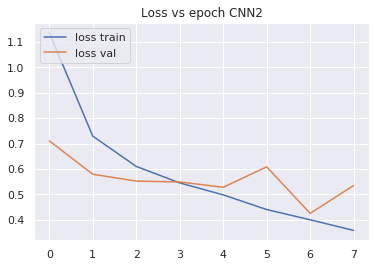

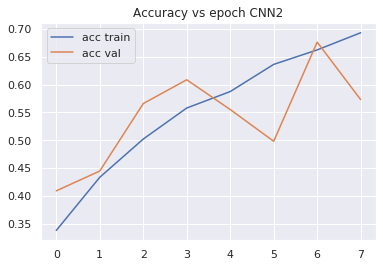


------ Training ------
Accuracy cnn2 : 0.75932699341624
F1-score None cnn2 : [0.70225225 0.81655123 0.86758576 0.62556175]
F1-score macro cnn2 : 0.7529877496045306

------ Validation ------
Accuracy cnn2 : 0.5729537366548043
F1-score None cnn2 : [0.4        0.25531915 0.47524752 0.71197411]
F1-score macro cnn2 : 0.460635195930252

------ Testing ------
Accuracy cnn2 : 0.5808031341821743
F1-score None cnn2 : [0.09615385 0.2247191  0.50720461 0.70996979]
F1-score macro cnn2 : 0.38451183668702194


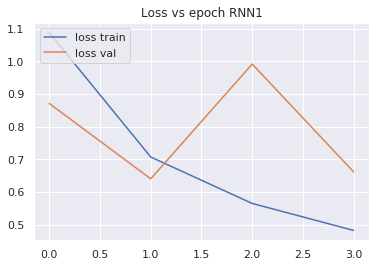

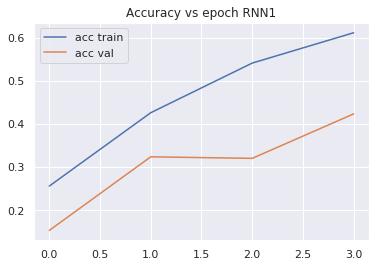


------ Training ------
Accuracy rnn1 : 0.5865947329919532
F1-score None rnn1 : [0.68459274 0.57218289 0.68683812 0.36573225]
F1-score macro rnn1 : 0.5773364999517103

------ Validation ------
Accuracy rnn1 : 0.4234875444839858
F1-score None rnn1 : [0.58064516 0.11666667 0.68852459 0.40707965]
F1-score macro rnn1 : 0.44822901603465576

------ Testing ------
Accuracy rnn1 : 0.3006856023506366
F1-score None rnn1 : [0.21319797 0.17443609 0.52631579 0.35633368]
F1-score macro rnn1 : 0.3175708814661086


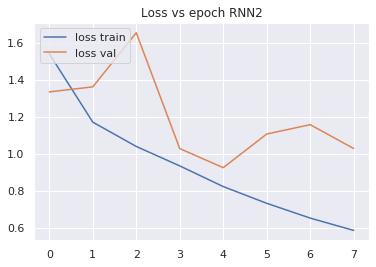

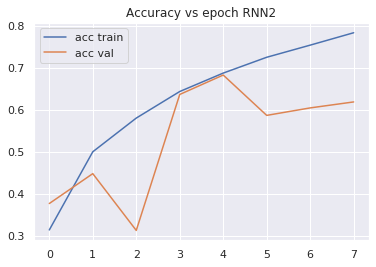


------ Training ------
Accuracy rnn2 : 0.8329370885149964
F1-score None rnn2 : [0.77357403 0.89093589 0.93556929 0.7275664 ]
F1-score macro rnn2 : 0.8319114028677014

------ Validation ------
Accuracy rnn2 : 0.6192170818505338
F1-score None rnn2 : [0.57333333 0.17391304 0.64615385 0.70431894]
F1-score macro rnn2 : 0.5244297899606293

------ Testing ------
Accuracy rnn2 : 0.5954946131243879
F1-score None rnn2 : [0.13930348 0.21428571 0.50922509 0.73362445]
F1-score macro rnn2 : 0.39910968581804324


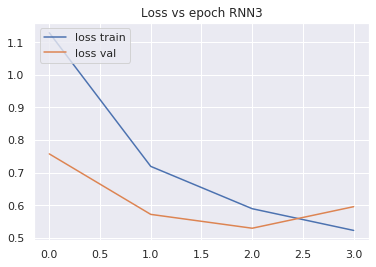

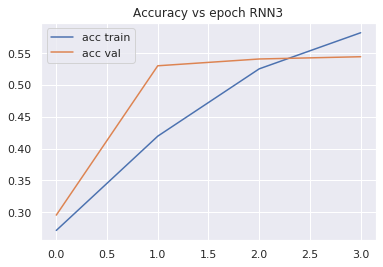


------ Training ------
Accuracy rnn3 : 0.6231711777615215
F1-score None rnn3 : [0.68077475 0.56977943 0.74187779 0.44181626]
F1-score macro rnn3 : 0.6085620580156686

------ Validation ------
Accuracy rnn3 : 0.5444839857651246
F1-score None rnn3 : [0.59393939 0.27777778 0.5        0.56704981]
F1-score macro rnn3 : 0.48469174503657264

------ Testing ------
Accuracy rnn3 : 0.42311459353574926
F1-score None rnn3 : [0.2122449  0.17142857 0.43583535 0.52898551]
F1-score macro rnn3 : 0.33712358193093006

Entrenando exec  3 



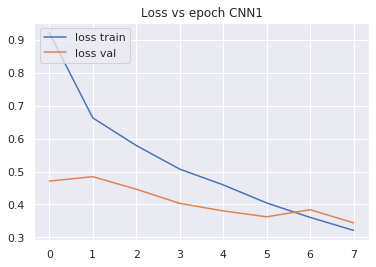

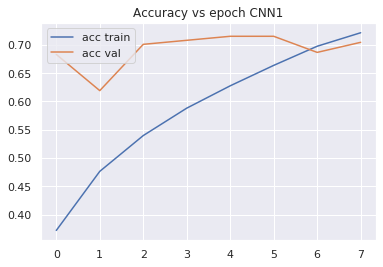


------ Training ------
Accuracy cnn1 : 0.8396122896854425
F1-score None cnn1 : [0.78923412 0.90047022 0.94414608 0.73519334]
F1-score macro cnn1 : 0.8422609400971394

------ Validation ------
Accuracy cnn1 : 0.7046263345195729
F1-score None cnn1 : [0.6        0.4        0.64705882 0.77844311]
F1-score macro cnn1 : 0.6063754843254667

------ Testing ------
Accuracy cnn1 : 0.722820763956905
F1-score None cnn1 : [0.125      0.25396825 0.6440678  0.82942708]
F1-score macro cnn1 : 0.46311578347793925


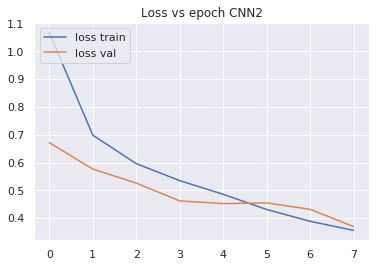

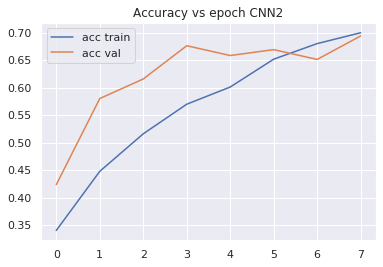


------ Training ------
Accuracy cnn2 : 0.780175566934894
F1-score None cnn2 : [0.65959953 0.85557809 0.9079817  0.68981754]
F1-score macro cnn2 : 0.7782442149775763

------ Validation ------
Accuracy cnn2 : 0.693950177935943
F1-score None cnn2 : [0.46153846 0.35294118 0.65753425 0.7826087 ]
F1-score macro cnn2 : 0.5636556450591416

------ Testing ------
Accuracy cnn2 : 0.7238001958863859
F1-score None cnn2 : [0.04705882 0.20689655 0.55172414 0.83172147]
F1-score macro cnn2 : 0.4093502458009816


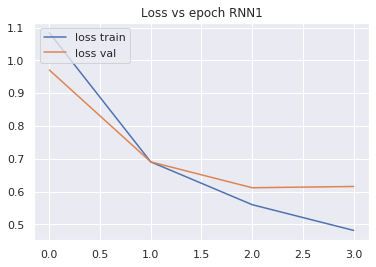

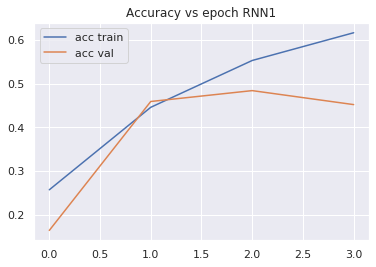


------ Training ------
Accuracy rnn1 : 0.6467629846378932
F1-score None rnn1 : [0.66940966 0.65089457 0.79508937 0.40150754]
F1-score macro rnn1 : 0.6292252843803877

------ Validation ------
Accuracy rnn1 : 0.45195729537366547
F1-score None rnn1 : [0.54143646 0.13157895 0.62337662 0.42982456]
F1-score macro rnn1 : 0.4315541490592377

------ Testing ------
Accuracy rnn1 : 0.33006856023506365
F1-score None rnn1 : [0.18587361 0.2019802  0.53046595 0.37815976]
F1-score macro rnn1 : 0.32411987777979573


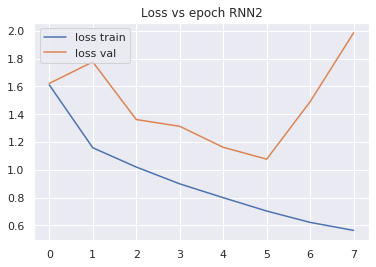

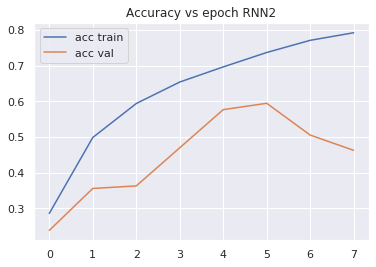


------ Training ------
Accuracy rnn2 : 0.6260972933430871
F1-score None rnn2 : [0.54165565 0.77535624 0.63711389 0.52553235]
F1-score macro rnn2 : 0.619914533603672

------ Validation ------
Accuracy rnn2 : 0.4626334519572954
F1-score None rnn2 : [0.44897959 0.30769231 0.32911392 0.55714286]
F1-score macro rnn2 : 0.4107321701806331

------ Testing ------
Accuracy rnn2 : 0.42703232125367285
F1-score None rnn2 : [0.07317073 0.19736842 0.29850746 0.55887522]
F1-score macro rnn2 : 0.28198045878254285


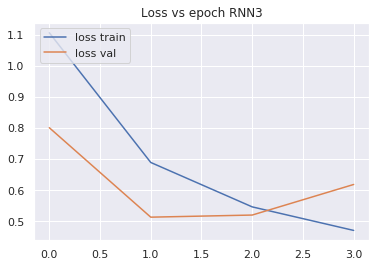

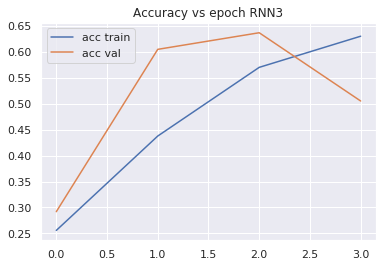


------ Training ------
Accuracy rnn3 : 0.6395391367959035
F1-score None rnn3 : [0.65839572 0.61487365 0.77297583 0.49315664]
F1-score macro rnn3 : 0.6348504596476843

------ Validation ------
Accuracy rnn3 : 0.505338078291815
F1-score None rnn3 : [0.56944444 0.1038961  0.5974026  0.56060606]
F1-score macro rnn3 : 0.45783730158730157

------ Testing ------
Accuracy rnn3 : 0.42605288932419194
F1-score None rnn3 : [0.13114754 0.18951613 0.49840256 0.54365437]
F1-score macro rnn3 : 0.34068014784073786

Entrenando exec  4 



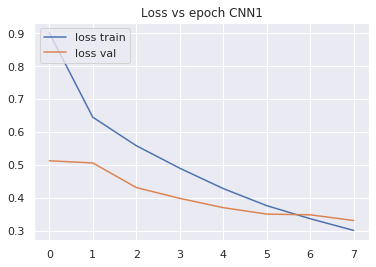

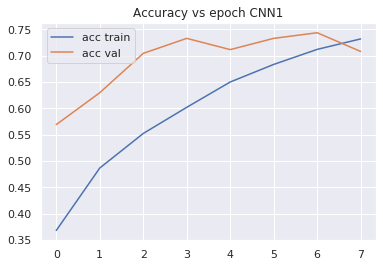


------ Training ------
Accuracy cnn1 : 0.8174835405998537
F1-score None cnn1 : [0.72144112 0.87892736 0.95496783 0.72246172]
F1-score macro cnn1 : 0.8194495091956415

------ Validation ------
Accuracy cnn1 : 0.708185053380783
F1-score None cnn1 : [0.52631579 0.26666667 0.65517241 0.78933333]
F1-score macro cnn1 : 0.5593720508166969

------ Testing ------
Accuracy cnn1 : 0.7355533790401567
F1-score None cnn1 : [0.05769231 0.14545455 0.59915612 0.84098052]
F1-score macro cnn1 : 0.4108208716723583


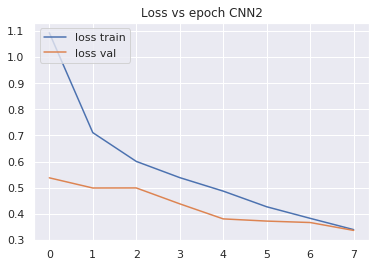

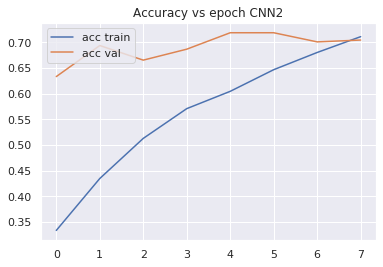


------ Training ------
Accuracy cnn2 : 0.8117227505486466
F1-score None cnn2 : [0.74070928 0.88076622 0.93530499 0.70815127]
F1-score macro cnn2 : 0.816232941909393

------ Validation ------
Accuracy cnn2 : 0.7046263345195729
F1-score None cnn2 : [0.56716418 0.27272727 0.65454545 0.79202279]
F1-score macro cnn2 : 0.5716149245999993

------ Testing ------
Accuracy cnn2 : 0.7277179236043095
F1-score None cnn2 : [0.08849558 0.2        0.5971564  0.83776933]
F1-score macro cnn2 : 0.43085532539728233


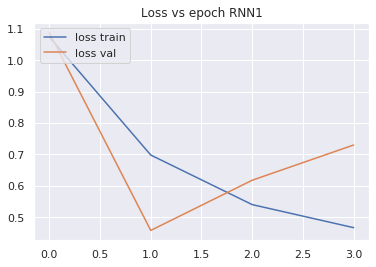

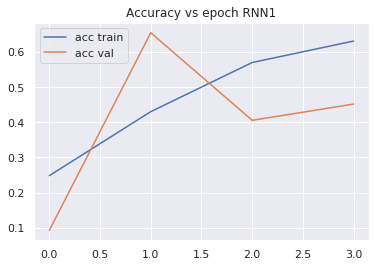


------ Training ------
Accuracy rnn1 : 0.6582845647403073
F1-score None rnn1 : [0.69414484 0.67164407 0.78094334 0.38220584]
F1-score macro rnn1 : 0.6322345208921675

------ Validation ------
Accuracy rnn1 : 0.45195729537366547
F1-score None rnn1 : [0.58666667 0.17721519 0.46938776 0.45106383]
F1-score macro rnn1 : 0.42108336035733984

------ Testing ------
Accuracy rnn1 : 0.2938295788442703
F1-score None rnn1 : [0.22330097 0.19512195 0.38926174 0.31130064]
F1-score macro rnn1 : 0.27974632667964755


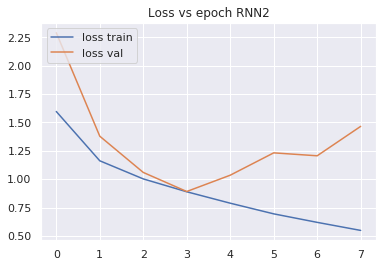

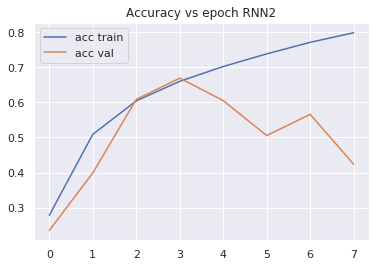


------ Training ------
Accuracy rnn2 : 0.7779809802487199
F1-score None rnn2 : [0.75458542 0.86465177 0.93519189 0.43898444]
F1-score macro rnn2 : 0.7483533801287346

------ Validation ------
Accuracy rnn2 : 0.4234875444839858
F1-score None rnn2 : [0.52380952 0.1971831  0.61290323 0.34703196]
F1-score macro rnn2 : 0.4202319529194611

------ Testing ------
Accuracy rnn2 : 0.2997061704211557
F1-score None rnn2 : [0.14553015 0.17857143 0.5203252  0.36159346]
F1-score macro rnn2 : 0.3015050600176662


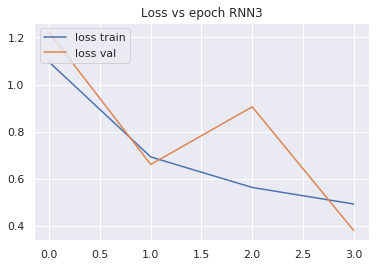

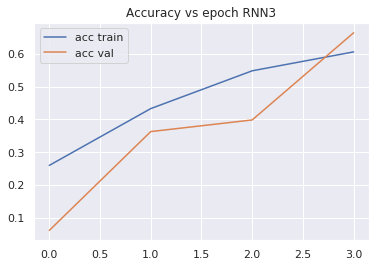


------ Training ------
Accuracy rnn3 : 0.5857717629846378
F1-score None rnn3 : [0.667789   0.30513595 0.74327981 0.53590512]
F1-score macro rnn3 : 0.5630274717539485

------ Validation ------
Accuracy rnn3 : 0.6654804270462633
F1-score None rnn3 : [0.57142857 0.14285714 0.64788732 0.73684211]
F1-score macro rnn3 : 0.5247537858731336

------ Testing ------
Accuracy rnn3 : 0.6297747306562194
F1-score None rnn3 : [0.15246637 0.22429907 0.53846154 0.75315568]
F1-score macro rnn3 : 0.4170956629548769

Entrenando exec  5 



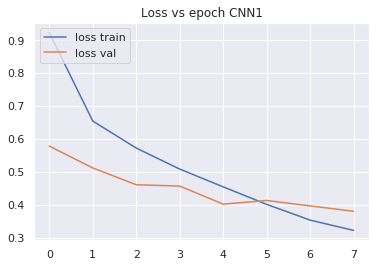

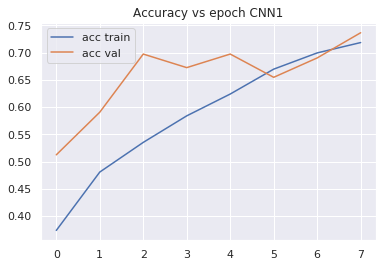


------ Training ------
Accuracy cnn1 : 0.8293708851499634
F1-score None cnn1 : [0.78842975 0.89129153 0.91134091 0.73006947]
F1-score macro cnn1 : 0.8302829130359021

------ Validation ------
Accuracy cnn1 : 0.7366548042704626
F1-score None cnn1 : [0.63703704 0.375      0.68493151 0.80473373]
F1-score macro cnn1 : 0.6254255679242507

------ Testing ------
Accuracy cnn1 : 0.7012732615083251
F1-score None cnn1 : [0.09259259 0.22222222 0.54605263 0.8129544 ]
F1-score macro cnn1 : 0.4184554604087512


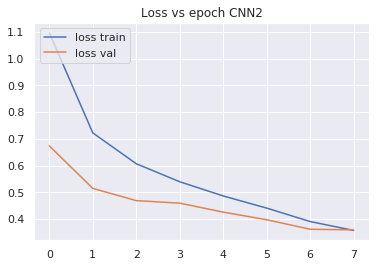

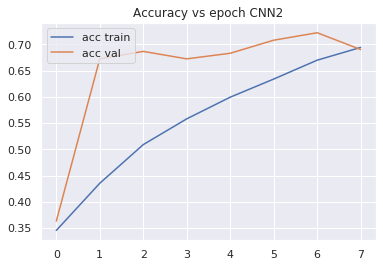


------ Training ------
Accuracy cnn2 : 0.806693489392831
F1-score None cnn2 : [0.74114441 0.85377358 0.93468745 0.70231672]
F1-score macro cnn2 : 0.8079805423012221

------ Validation ------
Accuracy cnn2 : 0.6903914590747331
F1-score None cnn2 : [0.57777778 0.3        0.62686567 0.77058824]
F1-score macro cnn2 : 0.5688079211784216

------ Testing ------
Accuracy cnn2 : 0.6875612144955926
F1-score None cnn2 : [0.1875     0.13888889 0.56505576 0.8047968 ]
F1-score macro cnn2 : 0.42406036327564633


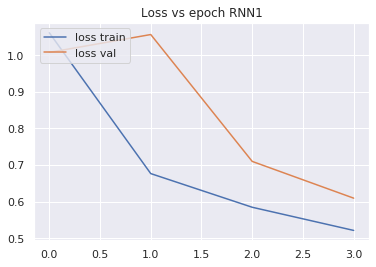

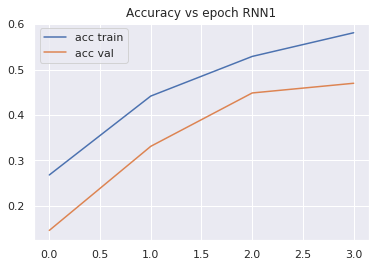


------ Training ------
Accuracy rnn1 : 0.6193306510607169
F1-score None rnn1 : [0.67185979 0.59625512 0.74936982 0.42742121]
F1-score macro rnn1 : 0.6112264848293814

------ Validation ------
Accuracy rnn1 : 0.4697508896797153
F1-score None rnn1 : [0.57718121 0.13953488 0.53658537 0.49795918]
F1-score macro rnn1 : 0.4378151603254374

------ Testing ------
Accuracy rnn1 : 0.3721841332027424
F1-score None rnn1 : [0.21978022 0.17786561 0.50625    0.45261122]
F1-score macro rnn1 : 0.3391267627492766


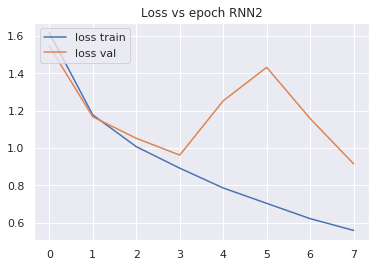

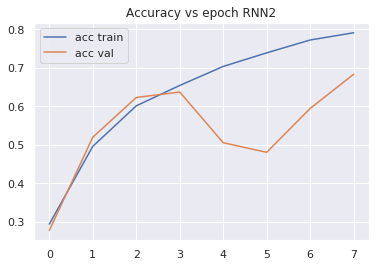


------ Training ------
Accuracy rnn2 : 0.761521580102414
F1-score None rnn2 : [0.79571128 0.68363979 0.89920109 0.66063765]
F1-score macro rnn2 : 0.7597974507727621

------ Validation ------
Accuracy rnn2 : 0.6832740213523132
F1-score None rnn2 : [0.6122449  0.23529412 0.63888889 0.74846626]
F1-score macro rnn2 : 0.5587235405409607

------ Testing ------
Accuracy rnn2 : 0.6444662095984329
F1-score None rnn2 : [0.19095477 0.14414414 0.54362416 0.76708508]
F1-score macro rnn2 : 0.411452038948956


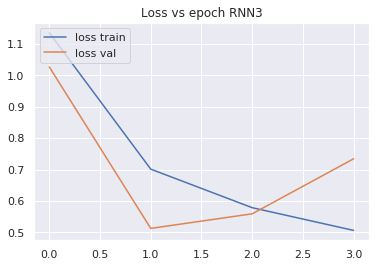

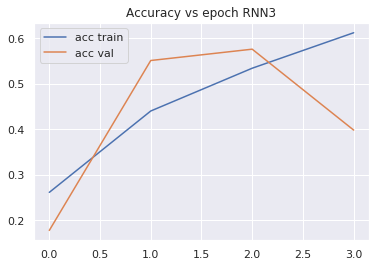


------ Training ------
Accuracy rnn3 : 0.6237198244330651
F1-score None rnn3 : [0.68920676 0.62004205 0.74515333 0.34782609]
F1-score macro rnn3 : 0.6005570565548599

------ Validation ------
Accuracy rnn3 : 0.398576512455516
F1-score None rnn3 : [0.57324841 0.11881188 0.51685393 0.35348837]
F1-score macro rnn3 : 0.3906006483771809

------ Testing ------
Accuracy rnn3 : 0.26346718903036237
F1-score None rnn3 : [0.18032787 0.16931217 0.46835443 0.27322404]
F1-score macro rnn3 : 0.27280462806505557


In [16]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn1_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn1_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=False)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn3_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [17]:
print ("--------- Usando contexto positivo y negativo obligadamente ---------")

for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.15 Clase - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.15 Clase - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.15 Clase - Accuracy promedio para",key,":" ,temp/5)

--------- Usando contexto positivo y negativo obligadamente ---------
0.15 Clase - F1-score promedio para cnn1 : [0.11964601 0.22909091 0.60374778 0.81850093]
0.15 Clase - F1-score promedio para cnn2 : [0.10606387 0.19600567 0.55519592 0.80143344]
0.15 Clase - F1-score promedio para rnn1 : [0.21820833 0.18808302 0.50612135 0.42641373]
0.15 Clase - F1-score promedio para rnn2 : [0.15384469 0.18973108 0.49115054 0.63046275]
0.15 Clase - F1-score promedio para rnn3 : [0.17577788 0.19591119 0.48979808 0.56379197]

0.15 Clase - F1-score macro promedio para cnn1 : 0.4427464065626233 desvest:  0.023567491176409123
0.15 Clase - F1-score macro promedio para cnn2 : 0.41467472620204965 desvest:  0.016652212236685462
0.15 Clase - F1-score macro promedio para rnn1 : 0.3347066069445971 desvest:  0.04375137345081487
0.15 Clase - F1-score macro promedio para rnn2 : 0.3662972666665436 desvest:  0.06242454875843821
0.15 Clase - F1-score macro promedio para rnn3 : 0.3563197773863224 desvest:  0.054030493

In [18]:
macro_augmented = np.load('../Datasets/CSV_Stance/balance_clase_noPon_GloVe_pos.npy', allow_pickle=True)
np.random.shuffle(macro_augmented)

ids_train=macro_augmented[:,0]
tws_train=macro_augmented[:,1]
labels_train=macro_augmented[:,2]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
print ("Pesos de clases:", class_weights)

sentences = tws_train
n_labels = labels_train.copy()

input_ids = []
for sent in sentences:
    encoded_sent = [] 
    for wd in sent:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
y_train=to_categorical(n_labels,num_classes=4)
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1

Pesos de clases: [1. 1. 1. 1.]



Entrenando exec  1 



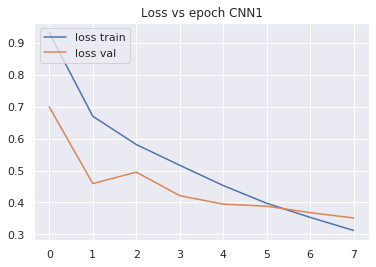

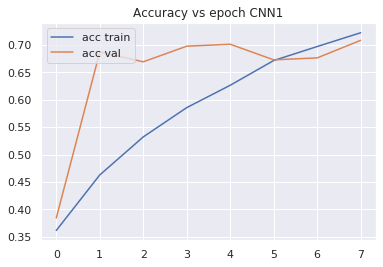


------ Training ------
Accuracy cnn1 : 0.8190380395025604
F1-score None cnn1 : [0.749843   0.87792208 0.94195392 0.71853335]
F1-score macro cnn1 : 0.8220630874592227

------ Validation ------
Accuracy cnn1 : 0.708185053380783
F1-score None cnn1 : [0.61068702 0.25       0.61538462 0.78285714]
F1-score macro cnn1 : 0.5647321952856305

------ Testing ------
Accuracy cnn1 : 0.7238001958863859
F1-score None cnn1 : [0.10434783 0.20168067 0.5917603  0.83322518]
F1-score macro cnn1 : 0.43275349410922015


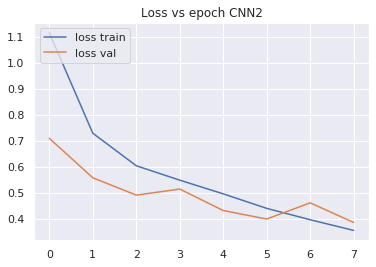

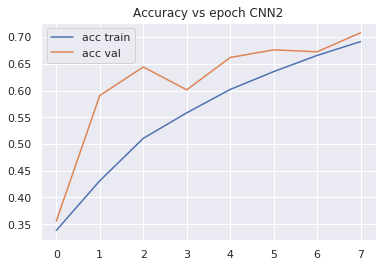


------ Training ------
Accuracy cnn2 : 0.7706656912948061
F1-score None cnn2 : [0.59212835 0.85631181 0.94168157 0.67460762]
F1-score macro cnn2 : 0.7661823399300397

------ Validation ------
Accuracy cnn2 : 0.708185053380783
F1-score None cnn2 : [0.54237288 0.30769231 0.68965517 0.79444444]
F1-score macro cnn2 : 0.5835412014766193

------ Testing ------
Accuracy cnn2 : 0.7375122428991185
F1-score None cnn2 : [0.025      0.26589595 0.61674009 0.84379001]
F1-score macro cnn2 : 0.43785651366676237


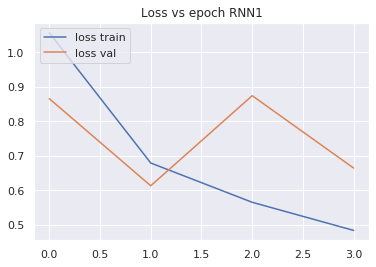

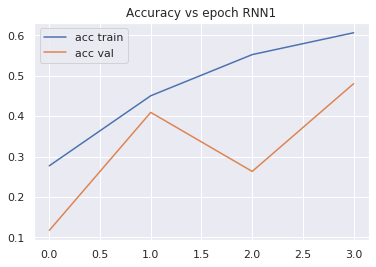


------ Training ------
Accuracy rnn1 : 0.6532553035844916
F1-score None rnn1 : [0.67596835 0.64350548 0.77743853 0.46937402]
F1-score macro rnn1 : 0.6415715941743769

------ Validation ------
Accuracy rnn1 : 0.4804270462633452
F1-score None rnn1 : [0.53731343 0.14925373 0.44660194 0.5503876 ]
F1-score macro rnn1 : 0.42088917570647555

------ Testing ------
Accuracy rnn1 : 0.41919686581782567
F1-score None rnn1 : [0.22818792 0.21218962 0.45604396 0.5174954 ]
F1-score macro rnn1 : 0.3534792219270749


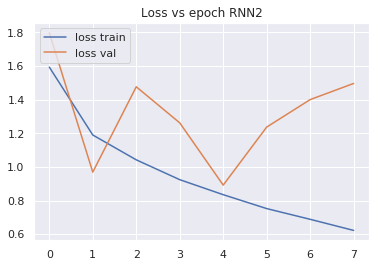

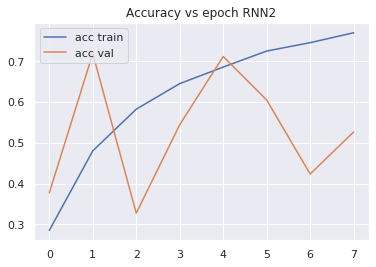


------ Training ------
Accuracy rnn2 : 0.7178127286027798
F1-score None rnn2 : [0.67213884 0.71969594 0.84022481 0.63624263]
F1-score macro rnn2 : 0.7170755547814145

------ Validation ------
Accuracy rnn2 : 0.5266903914590747
F1-score None rnn2 : [0.48598131 0.14285714 0.66666667 0.66431095]
F1-score macro rnn2 : 0.4899540179996571

------ Testing ------
Accuracy rnn2 : 0.4730656219392752
F1-score None rnn2 : [0.04       0.18846154 0.43523316 0.63466233]
F1-score macro rnn2 : 0.3245892565446249


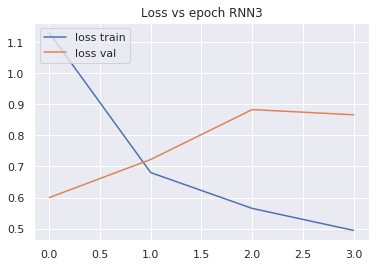

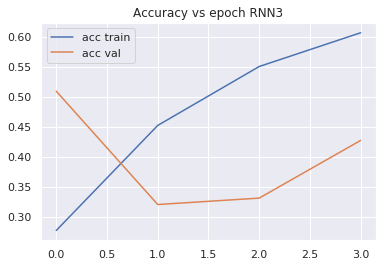


------ Training ------
Accuracy rnn3 : 0.5805596196049744
F1-score None rnn3 : [0.67976424 0.50542986 0.6570791  0.35859519]
F1-score macro rnn3 : 0.5502170998498557

------ Validation ------
Accuracy rnn3 : 0.42704626334519574
F1-score None rnn3 : [0.59210526 0.         0.34437086 0.42982456]
F1-score macro rnn3 : 0.341575171372139

------ Testing ------
Accuracy rnn3 : 0.31635651322233105
F1-score None rnn3 : [0.21940928 0.18025751 0.30948419 0.376931  ]
F1-score macro rnn3 : 0.2715204963529542

Entrenando exec  2 



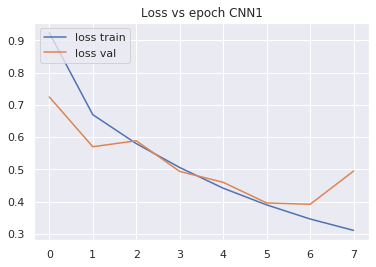

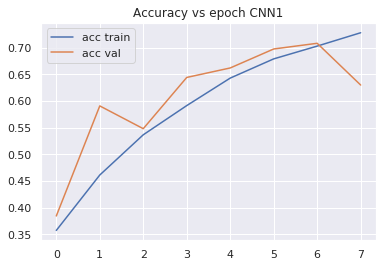


------ Training ------
Accuracy cnn1 : 0.7686539868324799
F1-score None cnn1 : [0.77311264 0.83578328 0.81865128 0.64824121]
F1-score macro cnn1 : 0.7689471006095416

------ Validation ------
Accuracy cnn1 : 0.6298932384341637
F1-score None cnn1 : [0.58646617 0.30769231 0.44642857 0.73026316]
F1-score macro cnn1 : 0.5177125506072875

------ Testing ------
Accuracy cnn1 : 0.6072477962781586
F1-score None cnn1 : [0.125      0.1980198  0.42758621 0.73875181]
F1-score macro cnn1 : 0.3723394557750655


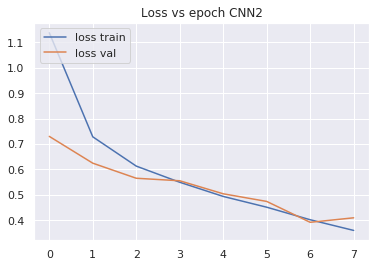

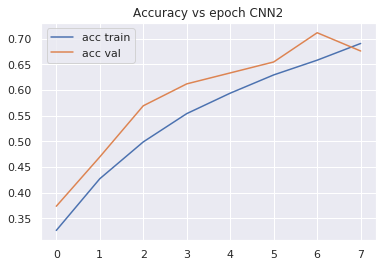


------ Training ------
Accuracy cnn2 : 0.7849305047549379
F1-score None cnn2 : [0.71350165 0.86229443 0.88114417 0.67981251]
F1-score macro cnn2 : 0.7841881903158854

------ Validation ------
Accuracy cnn2 : 0.6761565836298933
F1-score None cnn2 : [0.57575758 0.375      0.57471264 0.75840979]
F1-score macro cnn2 : 0.5709700013421146

------ Testing ------
Accuracy cnn2 : 0.66307541625857
F1-score None cnn2 : [0.12280702 0.1969697  0.51445087 0.78344828]
F1-score macro cnn2 : 0.40441896435691216


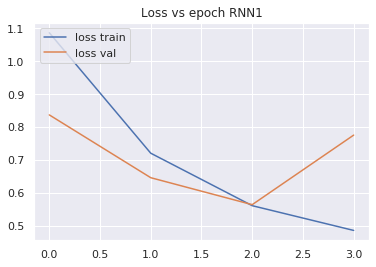

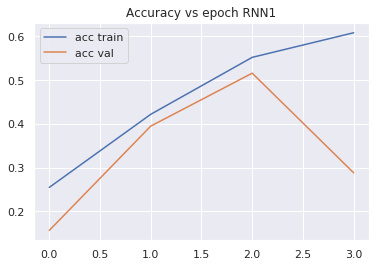


------ Training ------
Accuracy rnn1 : 0.5176481346013168
F1-score None rnn1 : [0.61006429 0.53788974 0.62012608 0.20754717]
F1-score macro rnn1 : 0.49390681868136427

------ Validation ------
Accuracy rnn1 : 0.28825622775800713
F1-score None rnn1 : [0.546875   0.08839779 0.54901961 0.23762376]
F1-score macro rnn1 : 0.3554790400686559

------ Testing ------
Accuracy rnn1 : 0.1762977473065622
F1-score None rnn1 : [0.13253012 0.1509434  0.48863636 0.14553991]
F1-score macro rnn1 : 0.22941244661199822


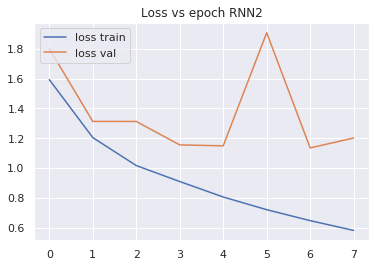

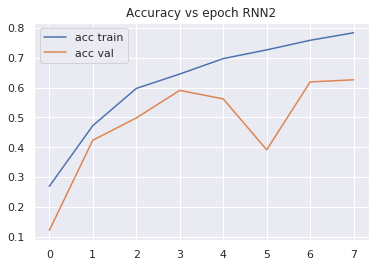


------ Training ------
Accuracy rnn2 : 0.7607900512070227
F1-score None rnn2 : [0.76408787 0.75363596 0.85909313 0.66162126]
F1-score macro rnn2 : 0.7596095540944102

------ Validation ------
Accuracy rnn2 : 0.6263345195729537
F1-score None rnn2 : [0.58503401 0.         0.53932584 0.7147541 ]
F1-score macro rnn2 : 0.45977848866568183

------ Testing ------
Accuracy rnn2 : 0.6258570029382958
F1-score None rnn2 : [0.24489796 0.16666667 0.47674419 0.7517934 ]
F1-score macro rnn2 : 0.4100255530459489


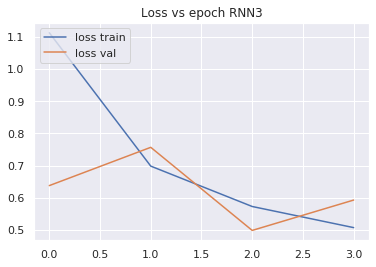

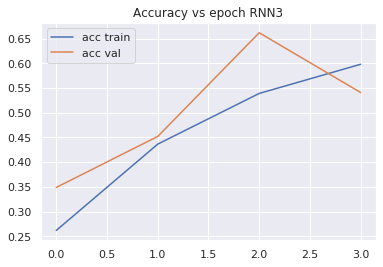


------ Training ------
Accuracy rnn3 : 0.6277432333577176
F1-score None rnn3 : [0.67592419 0.60949788 0.71901793 0.5017712 ]
F1-score macro rnn3 : 0.6265528000271856

------ Validation ------
Accuracy rnn3 : 0.5409252669039146
F1-score None rnn3 : [0.55555556 0.23728814 0.54054054 0.59925094]
F1-score macro rnn3 : 0.48315879200472606

------ Testing ------
Accuracy rnn3 : 0.4201762977473066
F1-score None rnn3 : [0.1965812  0.23766816 0.52671756 0.51636364]
F1-score macro rnn3 : 0.3693326379079297

Entrenando exec  3 



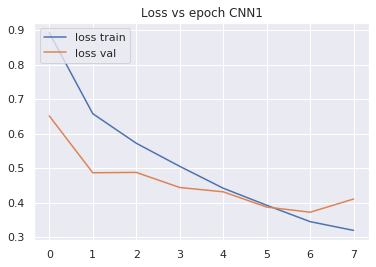

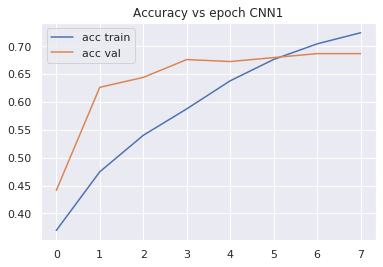


------ Training ------
Accuracy cnn1 : 0.8273591806876371
F1-score None cnn1 : [0.73384447 0.90688114 0.94226001 0.71744148]
F1-score macro cnn1 : 0.8251067742081866

------ Validation ------
Accuracy cnn1 : 0.6868327402135231
F1-score None cnn1 : [0.59090909 0.32432432 0.61290323 0.77945619]
F1-score macro cnn1 : 0.5768982085983353

------ Testing ------
Accuracy cnn1 : 0.6758080313418218
F1-score None cnn1 : [0.11009174 0.27312775 0.5984252  0.79476584]
F1-score macro cnn1 : 0.44410263337350253


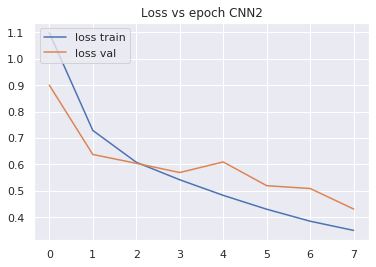

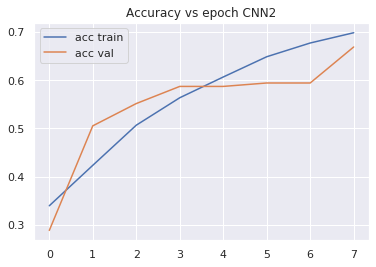


------ Training ------
Accuracy cnn2 : 0.7959948792977323
F1-score None cnn2 : [0.71794872 0.8732965  0.89527309 0.68453886]
F1-score macro cnn2 : 0.7927642935415633

------ Validation ------
Accuracy cnn2 : 0.6690391459074733
F1-score None cnn2 : [0.51724138 0.32258065 0.63157895 0.76106195]
F1-score macro cnn2 : 0.5581157296856778

------ Testing ------
Accuracy cnn2 : 0.6287952987267384
F1-score None cnn2 : [0.14414414 0.22222222 0.50737463 0.75466284]
F1-score macro cnn2 : 0.40710095959521436


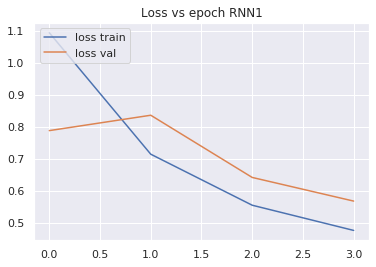

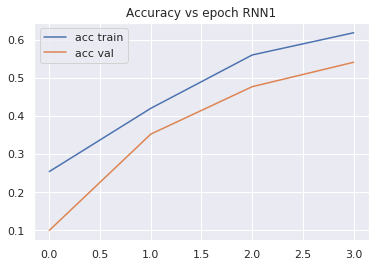


------ Training ------
Accuracy rnn1 : 0.6762984637893197
F1-score None rnn1 : [0.64629795 0.68134872 0.80722071 0.54095702]
F1-score macro rnn1 : 0.6689560990741871

------ Validation ------
Accuracy rnn1 : 0.5409252669039146
F1-score None rnn1 : [0.56521739 0.16901408 0.56790123 0.61764706]
F1-score macro rnn1 : 0.47994494230070517

------ Testing ------
Accuracy rnn1 : 0.43780607247796277
F1-score None rnn1 : [0.17142857 0.1987041  0.49032258 0.55447298]
F1-score macro rnn1 : 0.35373206017196646


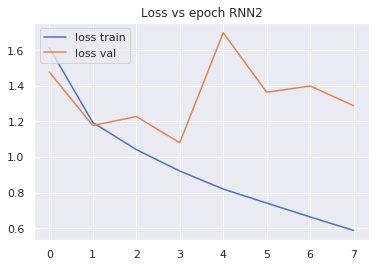

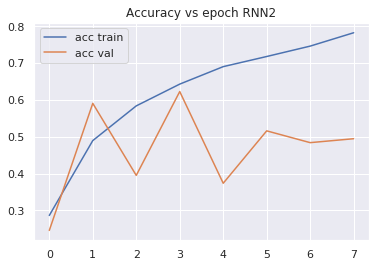


------ Training ------
Accuracy rnn2 : 0.7764264813460132
F1-score None rnn2 : [0.72998683 0.87797563 0.92079566 0.53138476]
F1-score macro rnn2 : 0.7650357210235506

------ Validation ------
Accuracy rnn2 : 0.49466192170818507
F1-score None rnn2 : [0.51886792 0.17142857 0.55384615 0.504     ]
F1-score macro rnn2 : 0.4370356624507568

------ Testing ------
Accuracy rnn2 : 0.41625857002938293
F1-score None rnn2 : [0.17943107 0.21698113 0.46963563 0.53818828]
F1-score macro rnn2 : 0.3510590272257339


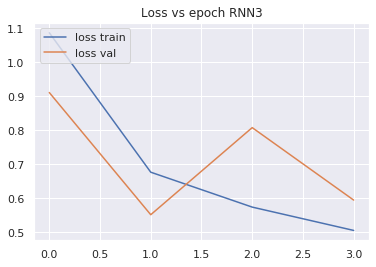

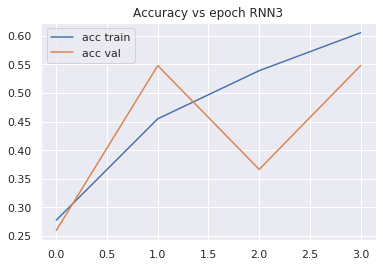


------ Training ------
Accuracy rnn3 : 0.6108266276517923
F1-score None rnn3 : [0.6641604  0.49853085 0.7063689  0.50323363]
F1-score macro rnn3 : 0.5930734456937414

------ Validation ------
Accuracy rnn3 : 0.5480427046263345
F1-score None rnn3 : [0.58064516 0.16       0.44642857 0.60740741]
F1-score macro rnn3 : 0.4486202850315754

------ Testing ------
Accuracy rnn3 : 0.44662095984329087
F1-score None rnn3 : [0.23430962 0.19767442 0.36842105 0.56288478]
F1-score macro rnn3 : 0.34082246979696523

Entrenando exec  4 



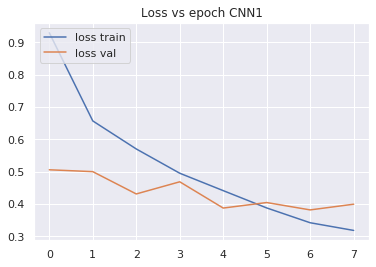

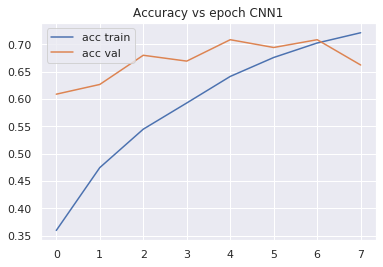


------ Training ------
Accuracy cnn1 : 0.8283650329188003
F1-score None cnn1 : [0.7844223  0.88716108 0.93914879 0.70897079]
F1-score macro cnn1 : 0.8299257399601457

------ Validation ------
Accuracy cnn1 : 0.6619217081850534
F1-score None cnn1 : [0.56603774 0.33333333 0.63636364 0.73354232]
F1-score macro cnn1 : 0.5673192563238106

------ Testing ------
Accuracy cnn1 : 0.6552399608227228
F1-score None cnn1 : [0.20960699 0.15929204 0.58461538 0.77777778]
F1-score macro cnn1 : 0.4328230461727389


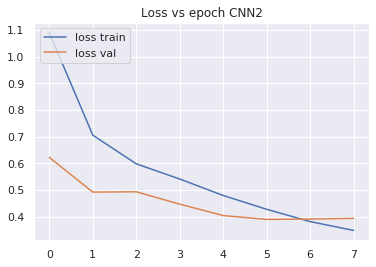

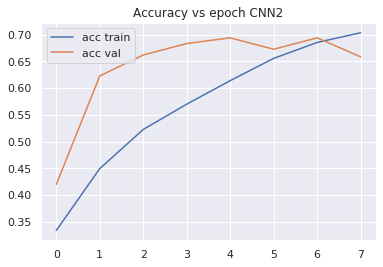


------ Training ------
Accuracy cnn2 : 0.7820958302852963
F1-score None cnn2 : [0.63013699 0.88059701 0.91543156 0.68937761]
F1-score macro cnn2 : 0.7788857917773075

------ Validation ------
Accuracy cnn2 : 0.6583629893238434
F1-score None cnn2 : [0.40384615 0.28571429 0.61764706 0.75880759]
F1-score macro cnn2 : 0.5165037716149625

------ Testing ------
Accuracy cnn2 : 0.7306562193927522
F1-score None cnn2 : [0.04761905 0.22900763 0.5620438  0.83966516]
F1-score macro cnn2 : 0.4195839102563994


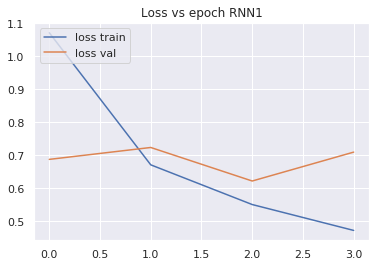

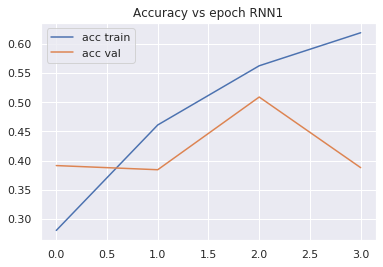


------ Training ------
Accuracy rnn1 : 0.5779992684711046
F1-score None rnn1 : [0.66172482 0.59891062 0.63104326 0.35939086]
F1-score macro rnn1 : 0.5627673912758536

------ Validation ------
Accuracy rnn1 : 0.3879003558718861
F1-score None rnn1 : [0.53488372 0.08474576 0.67857143 0.36111111]
F1-score macro rnn1 : 0.4148280058311592

------ Testing ------
Accuracy rnn1 : 0.2781586679725759
F1-score None rnn1 : [0.2        0.19017433 0.5026178  0.31368421]
F1-score macro rnn1 : 0.3016190845098408


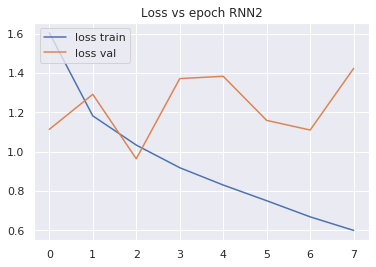

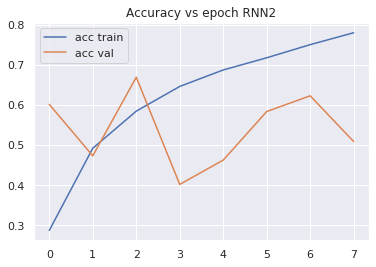


------ Training ------
Accuracy rnn2 : 0.7970007315288954
F1-score None rnn2 : [0.78453251 0.84370454 0.90793977 0.60908895]
F1-score macro rnn2 : 0.7863164431694608

------ Validation ------
Accuracy rnn2 : 0.5088967971530249
F1-score None rnn2 : [0.58108108 0.1875     0.5        0.54961832]
F1-score macro rnn2 : 0.45454985042294205

------ Testing ------
Accuracy rnn2 : 0.4427032321253673
F1-score None rnn2 : [0.12698413 0.20430108 0.46202532 0.56480687]
F1-score macro rnn2 : 0.3395293464153575


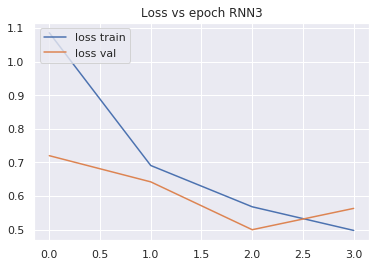

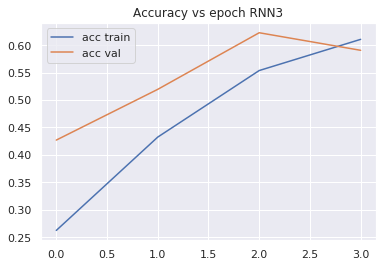


------ Training ------
Accuracy rnn3 : 0.6459400146305779
F1-score None rnn3 : [0.67596777 0.58682635 0.74763593 0.54017606]
F1-score macro rnn3 : 0.6376515294185164

------ Validation ------
Accuracy rnn3 : 0.5907473309608541
F1-score None rnn3 : [0.58108108 0.1875     0.51546392 0.66666667]
F1-score macro rnn3 : 0.4876779163183802

------ Testing ------
Accuracy rnn3 : 0.49559255631733595
F1-score None rnn3 : [0.26744186 0.22807018 0.39737991 0.61824324]
F1-score macro rnn3 : 0.37778379795267786

Entrenando exec  5 



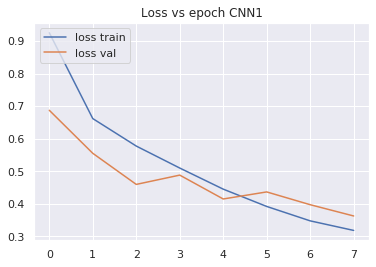

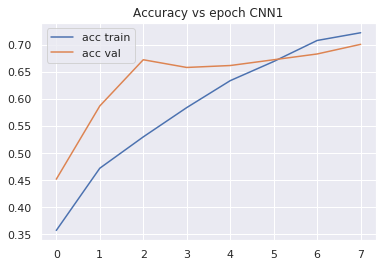


------ Training ------
Accuracy cnn1 : 0.7995610826627652
F1-score None cnn1 : [0.69916119 0.86856913 0.93640586 0.70277334]
F1-score macro cnn1 : 0.8017273800212183

------ Validation ------
Accuracy cnn1 : 0.701067615658363
F1-score None cnn1 : [0.53781513 0.375      0.61290323 0.78356164]
F1-score macro cnn1 : 0.577319998923122

------ Testing ------
Accuracy cnn1 : 0.7384916748285995
F1-score None cnn1 : [0.08163265 0.14814815 0.58369099 0.84092327]
F1-score macro cnn1 : 0.4135987643011758


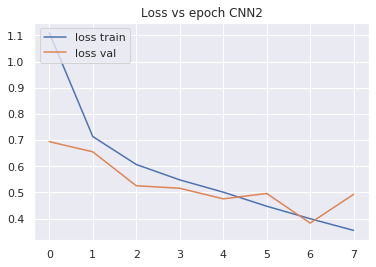

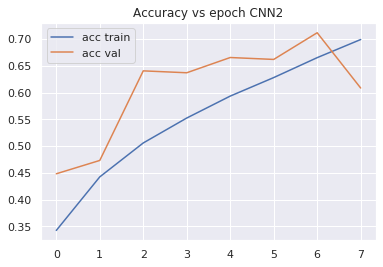


------ Training ------
Accuracy cnn2 : 0.7750548646671543
F1-score None cnn2 : [0.74257846 0.79904686 0.93387125 0.6       ]
F1-score macro cnn2 : 0.7688741423915125

------ Validation ------
Accuracy cnn2 : 0.608540925266904
F1-score None cnn2 : [0.60150376 0.19047619 0.64705882 0.69127517]
F1-score macro cnn2 : 0.5325784852973334

------ Testing ------
Accuracy cnn2 : 0.49559255631733595
F1-score None cnn2 : [0.10344828 0.20645161 0.60240964 0.62211221]
F1-score macro cnn2 : 0.38360543463515845


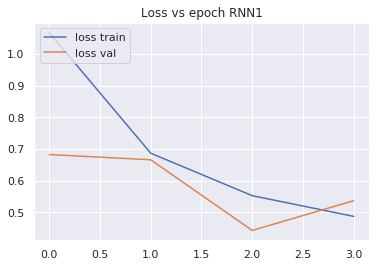

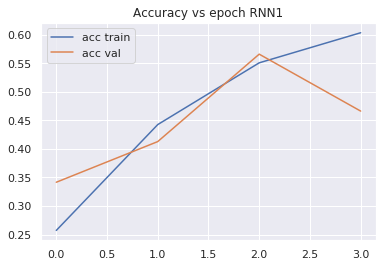


------ Training ------
Accuracy rnn1 : 0.6069861009509876
F1-score None rnn1 : [0.66645768 0.6485342  0.6914385  0.39157895]
F1-score macro rnn1 : 0.5995023336428573

------ Validation ------
Accuracy rnn1 : 0.46619217081850534
F1-score None rnn1 : [0.5049505  0.14814815 0.62068966 0.46774194]
F1-score macro rnn1 : 0.4353825584634845

------ Testing ------
Accuracy rnn1 : 0.3555337904015671
F1-score None rnn1 : [0.14888337 0.22099448 0.54545455 0.44194757]
F1-score macro rnn1 : 0.3393199902063911


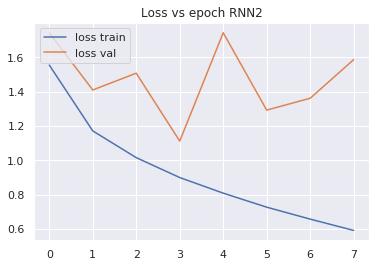

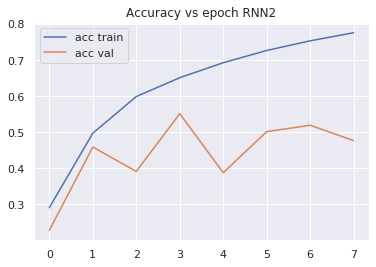


------ Training ------
Accuracy rnn2 : 0.7688368690563278
F1-score None rnn2 : [0.73945946 0.87049861 0.82210284 0.60774818]
F1-score macro rnn2 : 0.7599522745095498

------ Validation ------
Accuracy rnn2 : 0.47686832740213525
F1-score None rnn2 : [0.5483871  0.1509434  0.4137931  0.53531599]
F1-score macro rnn2 : 0.41210989539474907

------ Testing ------
Accuracy rnn2 : 0.5024485798237023
F1-score None rnn2 : [0.1322314  0.23321555 0.40776699 0.63295269]
F1-score macro rnn2 : 0.35154165865834525


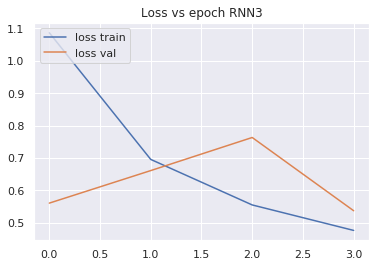

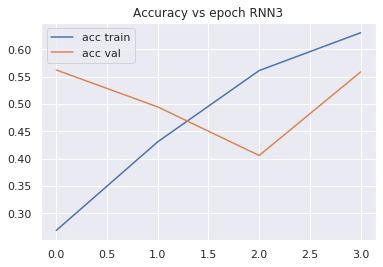


------ Training ------
Accuracy rnn3 : 0.64575713240673
F1-score None rnn3 : [0.67870761 0.58639665 0.73498434 0.54774436]
F1-score macro rnn3 : 0.6369582412052714

------ Validation ------
Accuracy rnn3 : 0.5587188612099644
F1-score None rnn3 : [0.56375839 0.14285714 0.47619048 0.62857143]
F1-score macro rnn3 : 0.45284435922019817

------ Testing ------
Accuracy rnn3 : 0.4701273261508325
F1-score None rnn3 : [0.22564103 0.21551724 0.40089087 0.58833619]
F1-score macro rnn3 : 0.3575963319317488


In [19]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn1_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn1_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=False)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn3_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [20]:
print ("--------- Usando contexto positivo obligadamente y negativo cuando es posible ---------")

for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.15 Clase - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.15 Clase - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.15 Clase - Accuracy promedio para",key,":" ,temp/5)

--------- Usando contexto positivo obligadamente y negativo cuando es posible ---------
0.15 Clase - F1-score promedio para cnn1 : [0.12613584 0.19605368 0.55721562 0.79708878]
0.15 Clase - F1-score promedio para cnn2 : [0.0886037  0.22410942 0.5606038  0.7687357 ]
0.15 Clase - F1-score promedio para rnn1 : [0.176206   0.19460118 0.49661505 0.39462801]
0.15 Clase - F1-score promedio para rnn2 : [0.14470891 0.20192519 0.45028106 0.62448071]
0.15 Clase - F1-score promedio para rnn3 : [0.2286766  0.2118375  0.40057872 0.53255177]

0.15 Clase - F1-score macro promedio para cnn1 : 0.4191234787463406 desvest:  0.02536407265179565
0.15 Clase - F1-score macro promedio para cnn2 : 0.4105131565020893 desvest:  0.01790388514489491
0.15 Clase - F1-score macro promedio para rnn1 : 0.3155125606854543 desvest:  0.04706431669733311
0.15 Clase - F1-score macro promedio para rnn2 : 0.3553489683780021 desvest:  0.029047713935715723
0.15 Clase - F1-score macro promedio para rnn3 : 0.3434111467884552 desve

In [23]:
macro_augmented = np.load('../Datasets/CSV_Stance/balance_clase_Pon_GloVe.npy', allow_pickle=True)
np.random.shuffle(macro_augmented)

ids_train=macro_augmented[:,0]
tws_train=macro_augmented[:,1]
labels_train=macro_augmented[:,2]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
print ("Pesos de clases:", class_weights)

sentences = tws_train
n_labels = labels_train.copy()

input_ids = []
for sent in sentences:
    encoded_sent = [] 
    for wd in sent:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
y_train=to_categorical(n_labels,num_classes=4)
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1

Pesos de clases: [1. 1. 1. 1.]



Entrenando exec  1 



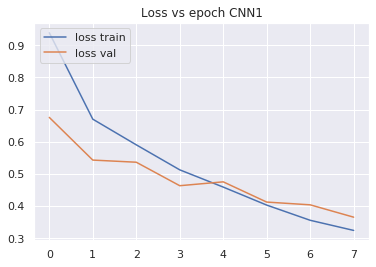

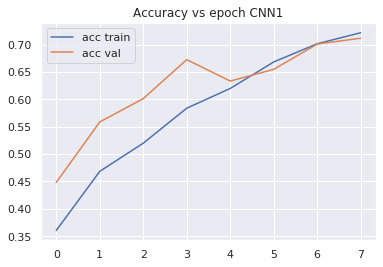


------ Training ------
Accuracy cnn1 : 0.8202267739575714
F1-score None cnn1 : [0.71666667 0.89264678 0.94480691 0.72360726]
F1-score macro cnn1 : 0.8194319055511633

------ Validation ------
Accuracy cnn1 : 0.7117437722419929
F1-score None cnn1 : [0.57575758 0.4        0.62686567 0.79883382]
F1-score macro cnn1 : 0.6003642666603373

------ Testing ------
Accuracy cnn1 : 0.7316356513222331
F1-score None cnn1 : [0.04545455 0.23287671 0.61111111 0.83676093]
F1-score macro cnn1 : 0.4315508235860738


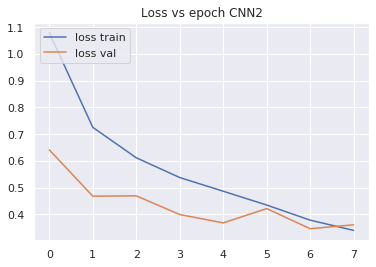

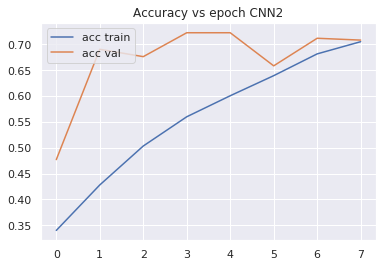


------ Training ------
Accuracy cnn2 : 0.8179407461594733
F1-score None cnn2 : [0.73686432 0.88380015 0.94386921 0.71437579]
F1-score macro cnn2 : 0.8197273666806328

------ Validation ------
Accuracy cnn2 : 0.708185053380783
F1-score None cnn2 : [0.62318841 0.41666667 0.59649123 0.78134111]
F1-score macro cnn2 : 0.604421852101416

------ Testing ------
Accuracy cnn2 : 0.6856023506366308
F1-score None cnn2 : [0.13333333 0.22966507 0.61538462 0.80428954]
F1-score macro cnn2 : 0.44566814118105214


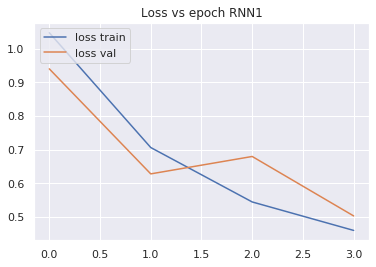

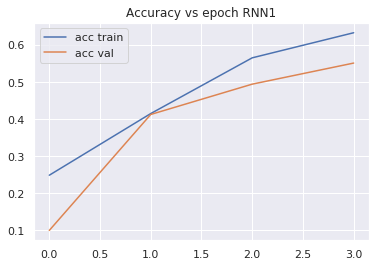


------ Training ------
Accuracy rnn1 : 0.6518836869056328
F1-score None rnn1 : [0.68300654 0.66964593 0.73787625 0.51495146]
F1-score macro rnn1 : 0.6513700432185487

------ Validation ------
Accuracy rnn1 : 0.5516014234875445
F1-score None rnn1 : [0.54054054 0.17391304 0.6440678  0.60294118]
F1-score macro rnn1 : 0.4903656392748898

------ Testing ------
Accuracy rnn1 : 0.4338883447600392
F1-score None rnn1 : [0.17475728 0.2311828  0.54634146 0.54844291]
F1-score macro rnn1 : 0.37518111181033786


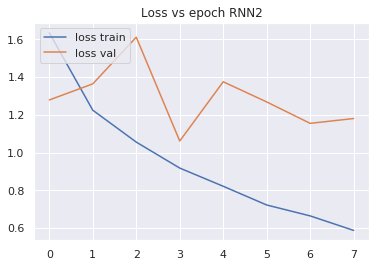

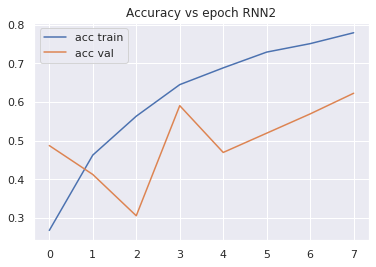


------ Training ------
Accuracy rnn2 : 0.797457937088515
F1-score None rnn2 : [0.77042654 0.8510978  0.89774462 0.67135325]
F1-score macro rnn2 : 0.7976555529750182

------ Validation ------
Accuracy rnn2 : 0.6227758007117438
F1-score None rnn2 : [0.5751634  0.25       0.54761905 0.69767442]
F1-score macro rnn2 : 0.5176142162291273

------ Testing ------
Accuracy rnn2 : 0.574926542605289
F1-score None rnn2 : [0.18556701 0.18994413 0.48929664 0.70342772]
F1-score macro rnn2 : 0.39205887507357007


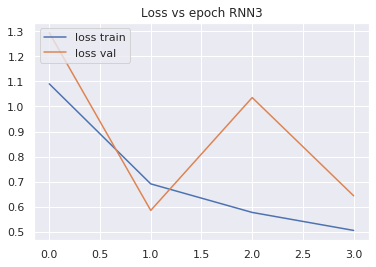

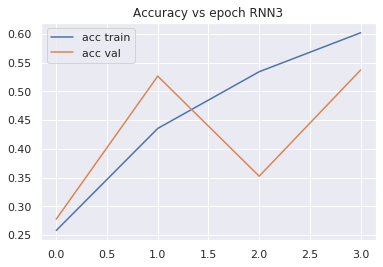


------ Training ------
Accuracy rnn3 : 0.6456656912948061
F1-score None rnn3 : [0.69753458 0.61454408 0.73565574 0.49631035]
F1-score macro rnn3 : 0.6360111875677498

------ Validation ------
Accuracy rnn3 : 0.5373665480427047
F1-score None rnn3 : [0.57746479 0.2173913  0.47169811 0.59701493]
F1-score macro rnn3 : 0.46589228291522544

------ Testing ------
Accuracy rnn3 : 0.40744368266405484
F1-score None rnn3 : [0.17391304 0.19512195 0.42081448 0.50551471]
F1-score macro rnn3 : 0.3238410450545337

Entrenando exec  2 



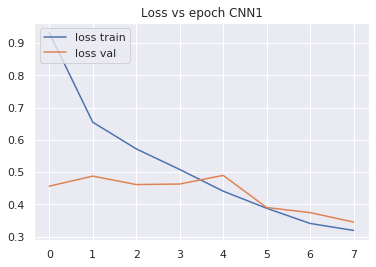

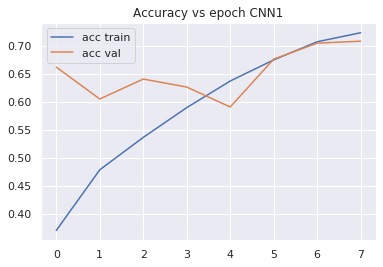


------ Training ------
Accuracy cnn1 : 0.8296452084857352
F1-score None cnn1 : [0.72518747 0.91080166 0.95326423 0.73195402]
F1-score macro cnn1 : 0.830301845320504

------ Validation ------
Accuracy cnn1 : 0.708185053380783
F1-score None cnn1 : [0.55737705 0.41666667 0.61818182 0.79224377]
F1-score macro cnn1 : 0.596117325335458

------ Testing ------
Accuracy cnn1 : 0.7257590597453477
F1-score None cnn1 : [0.1        0.2        0.60487805 0.83449588]
F1-score macro cnn1 : 0.4348434817575823


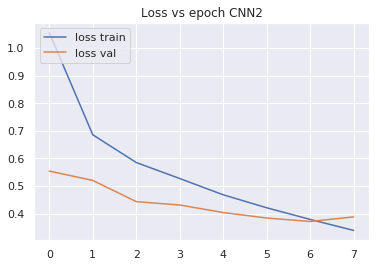

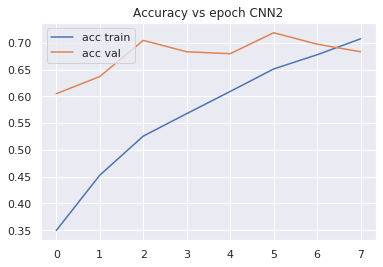


------ Training ------
Accuracy cnn2 : 0.8261704462326261
F1-score None cnn2 : [0.73939394 0.89533603 0.9468963  0.72207959]
F1-score macro cnn2 : 0.8259264648305333

------ Validation ------
Accuracy cnn2 : 0.6832740213523132
F1-score None cnn2 : [0.56692913 0.3125     0.61290323 0.77419355]
F1-score macro cnn2 : 0.5666314770129539

------ Testing ------
Accuracy cnn2 : 0.6885406464250735
F1-score None cnn2 : [0.10714286 0.25688073 0.62882096 0.80512475]
F1-score macro cnn2 : 0.4494923247301722


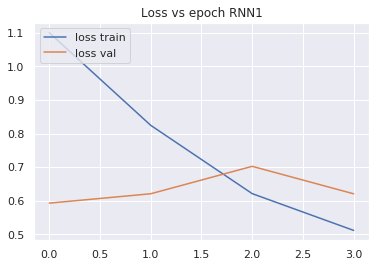

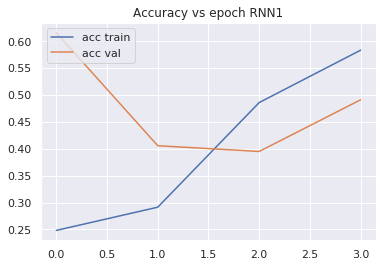


------ Training ------
Accuracy rnn1 : 0.6058888076079005
F1-score None rnn1 : [0.66859833 0.54096876 0.69968618 0.44362372]
F1-score macro rnn1 : 0.5882192499845856

------ Validation ------
Accuracy rnn1 : 0.49110320284697506
F1-score None rnn1 : [0.60689655 0.21052632 0.40625    0.50996016]
F1-score macro rnn1 : 0.4334082567190404

------ Testing ------
Accuracy rnn1 : 0.40646425073457393
F1-score None rnn1 : [0.26976744 0.22026432 0.35606061 0.49813433]
F1-score macro rnn1 : 0.3360566733649742


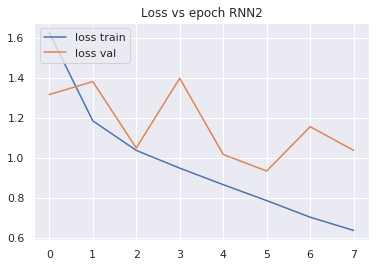

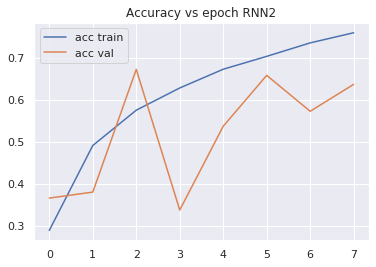


------ Training ------
Accuracy rnn2 : 0.8013899049012436
F1-score None rnn2 : [0.75795017 0.85037264 0.91730666 0.68818614]
F1-score macro rnn2 : 0.8034539018094686

------ Validation ------
Accuracy rnn2 : 0.6370106761565836
F1-score None rnn2 : [0.59722222 0.17647059 0.57575758 0.71698113]
F1-score macro rnn2 : 0.516607879572641

------ Testing ------
Accuracy rnn2 : 0.6307541625857003
F1-score None rnn2 : [0.2259887  0.19       0.53174603 0.76150035]
F1-score macro rnn2 : 0.4273087715420113


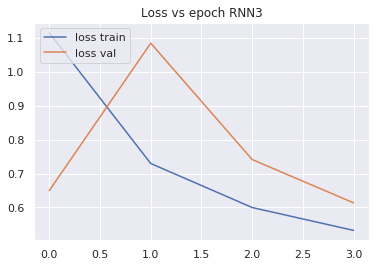

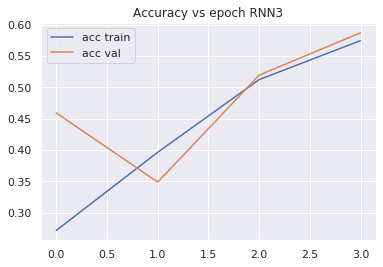


------ Training ------
Accuracy rnn3 : 0.6245427944403804
F1-score None rnn3 : [0.68210117 0.51738693 0.72349526 0.54576857]
F1-score macro rnn3 : 0.6171879831915073

------ Validation ------
Accuracy rnn3 : 0.5871886120996441
F1-score None rnn3 : [0.61111111 0.20408163 0.58139535 0.64310954]
F1-score macro rnn3 : 0.509924408309356

------ Testing ------
Accuracy rnn3 : 0.4838393731635651
F1-score None rnn3 : [0.2371134  0.20849421 0.39705882 0.61473328]
F1-score macro rnn3 : 0.36434992774236813

Entrenando exec  3 



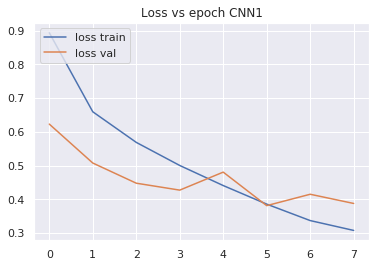

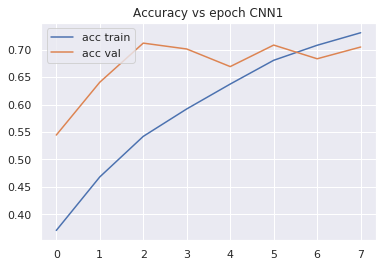


------ Training ------
Accuracy cnn1 : 0.8069678127286027
F1-score None cnn1 : [0.66777409 0.91473163 0.92470464 0.71082727]
F1-score macro cnn1 : 0.8045094064317362

------ Validation ------
Accuracy cnn1 : 0.7046263345195729
F1-score None cnn1 : [0.51785714 0.45454545 0.63888889 0.79213483]
F1-score macro cnn1 : 0.60085657943804

------ Testing ------
Accuracy cnn1 : 0.7267384916748286
F1-score None cnn1 : [0.025      0.2189781  0.5509434  0.83717949]
F1-score macro cnn1 : 0.4080252463989208


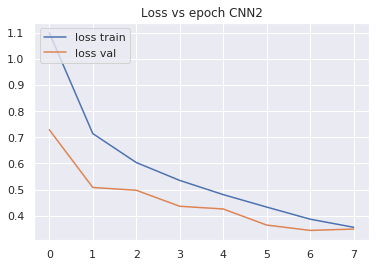

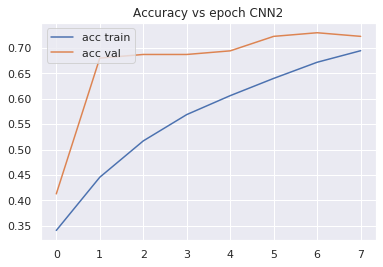


------ Training ------
Accuracy cnn2 : 0.813643013899049
F1-score None cnn2 : [0.74635818 0.87512063 0.92698302 0.7103929 ]
F1-score macro cnn2 : 0.8147136835251163

------ Validation ------
Accuracy cnn2 : 0.7224199288256228
F1-score None cnn2 : [0.5984252  0.52631579 0.66666667 0.78962536]
F1-score macro cnn2 : 0.645258253305323

------ Testing ------
Accuracy cnn2 : 0.7140058765915769
F1-score None cnn2 : [0.10619469 0.25       0.62948207 0.82213439]
F1-score macro cnn2 : 0.4519527873326032


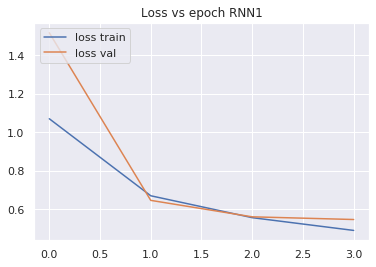

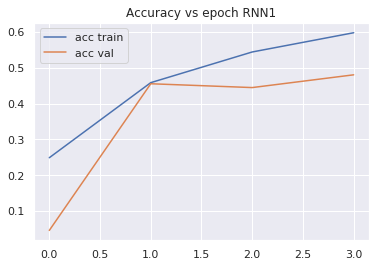


------ Training ------
Accuracy rnn1 : 0.5921726408193123
F1-score None rnn1 : [0.63729648 0.63172043 0.71325202 0.3439575 ]
F1-score macro rnn1 : 0.5815566082317276

------ Validation ------
Accuracy rnn1 : 0.4804270462633452
F1-score None rnn1 : [0.49122807 0.21052632 0.68852459 0.45957447]
F1-score macro rnn1 : 0.4624633610534883

------ Testing ------
Accuracy rnn1 : 0.385896180215475
F1-score None rnn1 : [0.1814059  0.20598007 0.61261261 0.47309833]
F1-score macro rnn1 : 0.36827422624764816


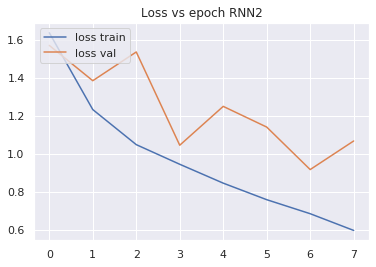

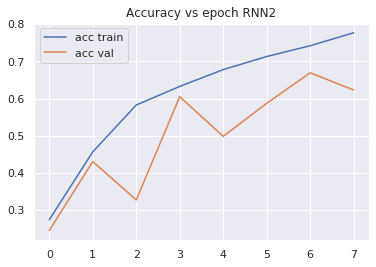


------ Training ------
Accuracy rnn2 : 0.7944403803950256
F1-score None rnn2 : [0.77910389 0.84169742 0.89884615 0.67708842]
F1-score macro rnn2 : 0.7991839716160805

------ Validation ------
Accuracy rnn2 : 0.6227758007117438
F1-score None rnn2 : [0.58503401 0.2173913  0.62068966 0.70096463]
F1-score macro rnn2 : 0.5310199008376907

------ Testing ------
Accuracy rnn2 : 0.6219392752203722
F1-score None rnn2 : [0.1025641  0.2295082  0.54545455 0.75484765]
F1-score macro rnn2 : 0.4080936225423306


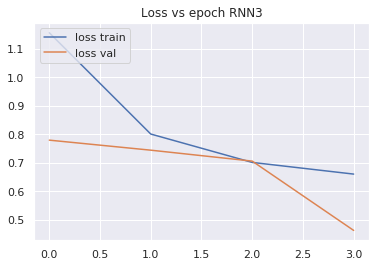

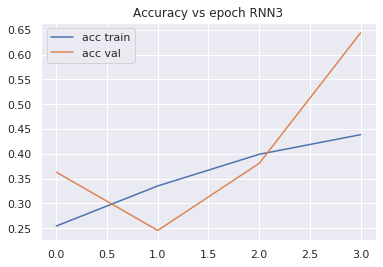


------ Training ------
Accuracy rnn3 : 0.5397768836869057
F1-score None rnn3 : [0.6532721  0.26601743 0.64400597 0.51690749]
F1-score macro rnn3 : 0.5200507475193371

------ Validation ------
Accuracy rnn3 : 0.6441281138790036
F1-score None rnn3 : [0.60689655 0.12121212 0.61333333 0.72491909]
F1-score macro rnn3 : 0.5165902750301813

------ Testing ------
Accuracy rnn3 : 0.6013712047012733
F1-score None rnn3 : [0.22727273 0.16666667 0.48850575 0.73841555]
F1-score macro rnn3 : 0.40521517166406607

Entrenando exec  4 



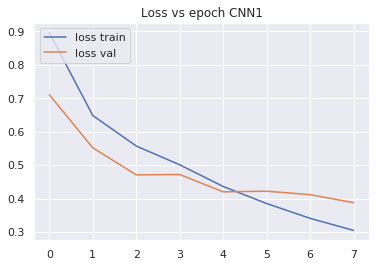

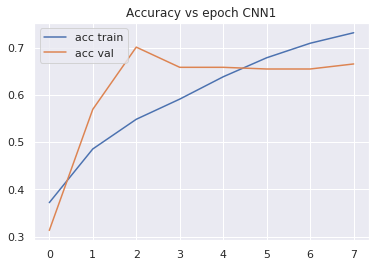


------ Training ------
Accuracy cnn1 : 0.8008412582297001
F1-score None cnn1 : [0.73737153 0.8619281  0.91557996 0.69779468]
F1-score macro cnn1 : 0.8031685671844512

------ Validation ------
Accuracy cnn1 : 0.6654804270462633
F1-score None cnn1 : [0.48275862 0.15384615 0.58974359 0.76056338]
F1-score macro cnn1 : 0.4967279361402722

------ Testing ------
Accuracy cnn1 : 0.7238001958863859
F1-score None cnn1 : [0.09803922 0.18947368 0.55813953 0.83031088]
F1-score macro cnn1 : 0.41899082890238437


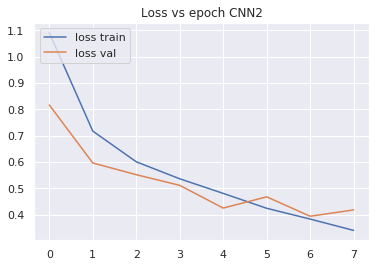

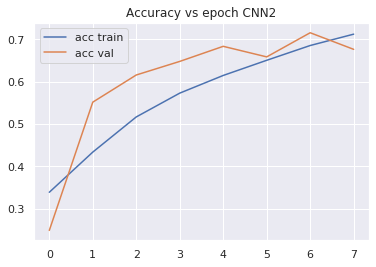


------ Training ------
Accuracy cnn2 : 0.7884967081199707
F1-score None cnn2 : [0.68527919 0.84767086 0.92224735 0.6751312 ]
F1-score macro cnn2 : 0.7825821489261245

------ Validation ------
Accuracy cnn2 : 0.6761565836298933
F1-score None cnn2 : [0.55737705 0.35       0.66666667 0.76219512]
F1-score macro cnn2 : 0.5840597094495534

------ Testing ------
Accuracy cnn2 : 0.6101860920666013
F1-score None cnn2 : [0.0625     0.2244898  0.5795053  0.73776479]
F1-score macro cnn2 : 0.4010649720226426


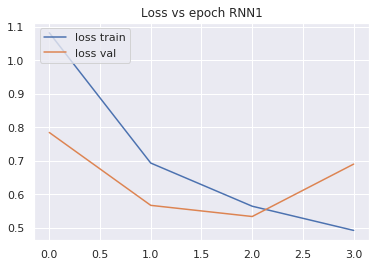

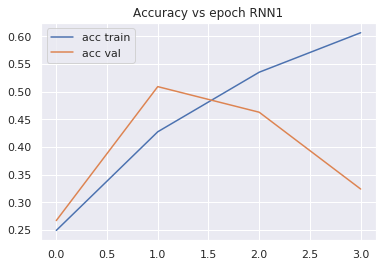


------ Training ------
Accuracy rnn1 : 0.5200256035113388
F1-score None rnn1 : [0.63109373 0.56133729 0.54196762 0.15731707]
F1-score macro rnn1 : 0.47292892761083827

------ Validation ------
Accuracy rnn1 : 0.3238434163701068
F1-score None rnn1 : [0.47257384 0.12048193 0.65454545 0.12834225]
F1-score macro rnn1 : 0.3439858669770125

------ Testing ------
Accuracy rnn1 : 0.21057786483839372
F1-score None rnn1 : [0.14977974 0.19366853 0.50847458 0.19221968]
F1-score macro rnn1 : 0.2610356301129832


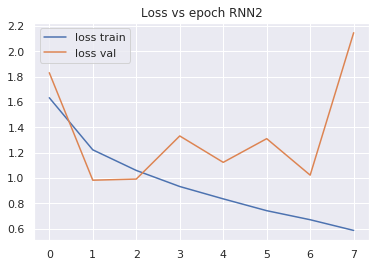

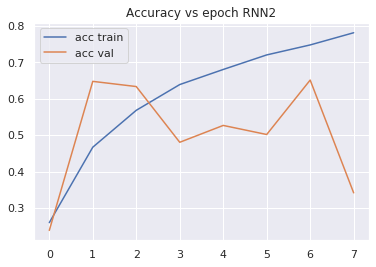


------ Training ------
Accuracy rnn2 : 0.6896488661302121
F1-score None rnn2 : [0.75850622 0.65318479 0.87560193 0.43832021]
F1-score macro rnn2 : 0.6814032876775108

------ Validation ------
Accuracy rnn2 : 0.3416370106761566
F1-score None rnn2 : [0.52554745 0.11464968 0.53061224 0.34703196]
F1-score macro rnn2 : 0.3794603337881039

------ Testing ------
Accuracy rnn2 : 0.31341821743388837
F1-score None rnn2 : [0.14285714 0.16833096 0.50847458 0.40234375]
F1-score macro rnn2 : 0.3055016062264475


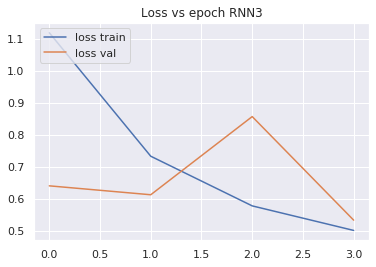

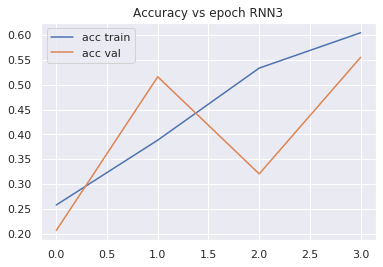


------ Training ------
Accuracy rnn3 : 0.6571872713972202
F1-score None rnn3 : [0.66946085 0.63768116 0.77765145 0.52390852]
F1-score macro rnn3 : 0.6521754966611206

------ Validation ------
Accuracy rnn3 : 0.5551601423487544
F1-score None rnn3 : [0.55263158 0.23255814 0.51612903 0.62043796]
F1-score macro rnn3 : 0.48043917673617403

------ Testing ------
Accuracy rnn3 : 0.46131243878550443
F1-score None rnn3 : [0.19298246 0.20846906 0.47536232 0.57659208]
F1-score macro rnn3 : 0.36335147824292563

Entrenando exec  5 



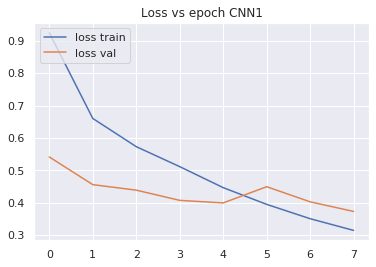

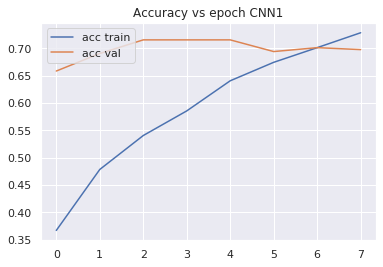


------ Training ------
Accuracy cnn1 : 0.8213240673006583
F1-score None cnn1 : [0.74484536 0.88682965 0.92430833 0.73253087]
F1-score macro cnn1 : 0.8221285556130172

------ Validation ------
Accuracy cnn1 : 0.697508896797153
F1-score None cnn1 : [0.56692913 0.375      0.62337662 0.77777778]
F1-score macro cnn1 : 0.5857708837531672

------ Testing ------
Accuracy cnn1 : 0.7375122428991185
F1-score None cnn1 : [0.04123711 0.27118644 0.61029412 0.83858521]
F1-score macro cnn1 : 0.44032572018257554


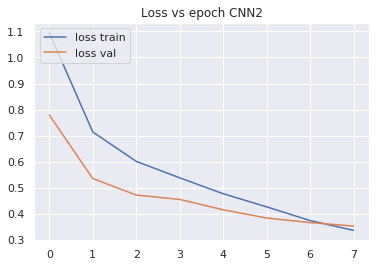

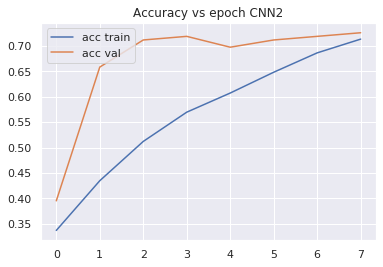


------ Training ------
Accuracy cnn2 : 0.748811265544989
F1-score None cnn2 : [0.74990654 0.6455915  0.94041132 0.64887972]
F1-score macro cnn2 : 0.7461972708009229

------ Validation ------
Accuracy cnn2 : 0.7259786476868327
F1-score None cnn2 : [0.63013699 0.30769231 0.66666667 0.79525223]
F1-score macro cnn2 : 0.599937046544908

------ Testing ------
Accuracy cnn2 : 0.7149853085210578
F1-score None cnn2 : [0.26041667 0.11904762 0.58870968 0.82608696]
F1-score macro cnn2 : 0.44856522991384495


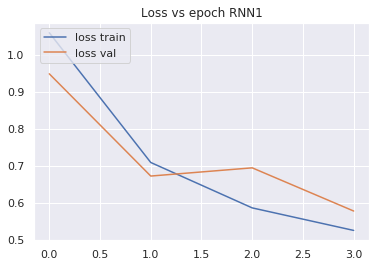

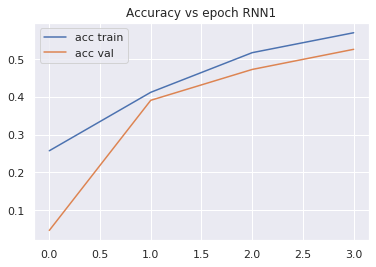


------ Training ------
Accuracy rnn1 : 0.6274689100219458
F1-score None rnn1 : [0.67826087 0.58023107 0.75907363 0.45390071]
F1-score macro rnn1 : 0.6178665675618507

------ Validation ------
Accuracy rnn1 : 0.5266903914590747
F1-score None rnn1 : [0.57142857 0.16       0.57831325 0.55172414]
F1-score macro rnn1 : 0.4653664905929136

------ Testing ------
Accuracy rnn1 : 0.39764936336924583
F1-score None rnn1 : [0.17266187 0.20652174 0.51234568 0.4869403 ]
F1-score macro rnn1 : 0.34461739678846004


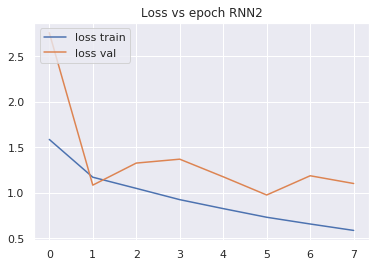

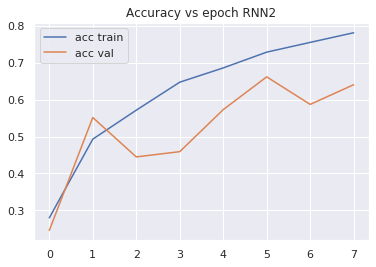


------ Training ------
Accuracy rnn2 : 0.7957205559619605
F1-score None rnn2 : [0.68822171 0.85458537 0.92728247 0.69289509]
F1-score macro rnn2 : 0.790746160543446

------ Validation ------
Accuracy rnn2 : 0.6405693950177936
F1-score None rnn2 : [0.53781513 0.23076923 0.58064516 0.75379939]
F1-score macro rnn2 : 0.5257572275518094

------ Testing ------
Accuracy rnn2 : 0.6199804113614104
F1-score None rnn2 : [0.06       0.21481481 0.51181102 0.75599436]
F1-score macro rnn2 : 0.38565504917198


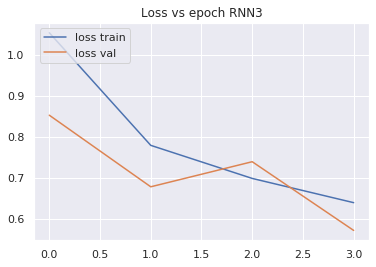

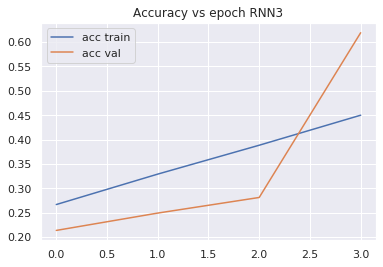


------ Training ------
Accuracy rnn3 : 0.5204828090709583
F1-score None rnn3 : [0.64537265 0.02380094 0.65013462 0.46993431]
F1-score macro rnn3 : 0.4473106278381809

------ Validation ------
Accuracy rnn3 : 0.6192170818505338
F1-score None rnn3 : [0.57647059 0.         0.56521739 0.68512111]
F1-score macro rnn3 : 0.45670227170151945

------ Testing ------
Accuracy rnn3 : 0.5014691478942214
F1-score None rnn3 : [0.21011673 0.         0.38271605 0.63843648]
F1-score macro rnn3 : 0.30781731574622906


In [24]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn1_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn1_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=False)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn3_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [25]:
print ("--------- Usando contexto positivo y negativo obligadamente ---------\n")

for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.15 Clase Ponderado - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.15 Clase Ponderado - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.15 Clase Ponderado - Accuracy promedio para",key,":" ,temp/5)

--------- Usando contexto positivo y negativo obligadamente ---------

0.15 Clase Ponderado - F1-score promedio para cnn1 : [0.06194617 0.22250299 0.58707324 0.83546648]
0.15 Clase Ponderado - F1-score promedio para cnn2 : [0.13391751 0.21601664 0.60838053 0.79908009]
0.15 Clase Ponderado - F1-score promedio para rnn1 : [0.18967445 0.21152349 0.50716699 0.43976711]
0.15 Clase Ponderado - F1-score promedio para rnn2 : [0.14339539 0.19851962 0.51735656 0.67562277]
0.15 Clase Ponderado - F1-score promedio para rnn3 : [0.20827967 0.15575038 0.43289148 0.61473842]

0.15 Clase Ponderado - F1-score macro promedio para cnn1 : 0.42674722016550737 desvest:  0.011693362454369676
0.15 Clase Ponderado - F1-score macro promedio para cnn2 : 0.43934869103606305 desvest:  0.019247232156816334
0.15 Clase Ponderado - F1-score macro promedio para rnn1 : 0.3370330076648807 desvest:  0.0406580106995844
0.15 Clase Ponderado - F1-score macro promedio para rnn2 : 0.38372358491126785 desvest:  0.041678418380319

In [26]:
macro_augmented = np.load('../Datasets/CSV_Stance/balance_clase_Pon_GloVe_pos.npy', allow_pickle=True)
np.random.shuffle(macro_augmented)

ids_train=macro_augmented[:,0]
tws_train=macro_augmented[:,1]
labels_train=macro_augmented[:,2]
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
print ("Pesos de clases:", class_weights)

sentences = tws_train
n_labels = labels_train.copy()

input_ids = []
for sent in sentences:
    encoded_sent = [] 
    for wd in sent:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
y_train=to_categorical(n_labels,num_classes=4)
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1

Pesos de clases: [1. 1. 1. 1.]



Entrenando exec  1 



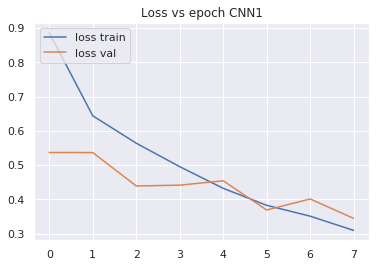

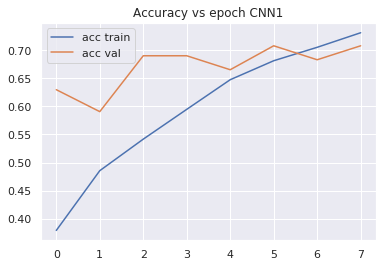


------ Training ------
Accuracy cnn1 : 0.8376920263350403
F1-score None cnn1 : [0.76865204 0.906641   0.94291908 0.74166142]
F1-score macro cnn1 : 0.8399683840006724

------ Validation ------
Accuracy cnn1 : 0.708185053380783
F1-score None cnn1 : [0.59259259 0.42105263 0.63636364 0.78362573]
F1-score macro cnn1 : 0.6084086478823321

------ Testing ------
Accuracy cnn1 : 0.722820763956905
F1-score None cnn1 : [0.05504587 0.17021277 0.62831858 0.83269476]
F1-score macro cnn1 : 0.4215679963292807


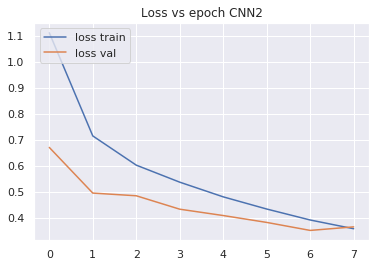

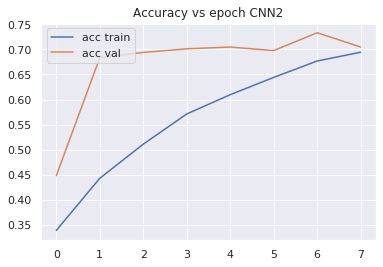


------ Training ------
Accuracy cnn2 : 0.8085223116313094
F1-score None cnn2 : [0.76253353 0.84790174 0.93057764 0.70659052]
F1-score macro cnn2 : 0.8119008564004144

------ Validation ------
Accuracy cnn2 : 0.7046263345195729
F1-score None cnn2 : [0.51968504 0.5        0.66666667 0.78857143]
F1-score macro cnn2 : 0.6187307836520436

------ Testing ------
Accuracy cnn2 : 0.7120470127326151
F1-score None cnn2 : [0.11570248 0.16666667 0.60392157 0.81888745]
F1-score macro cnn2 : 0.42629454153016766


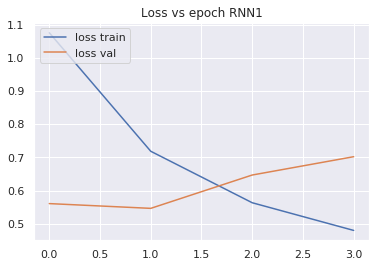

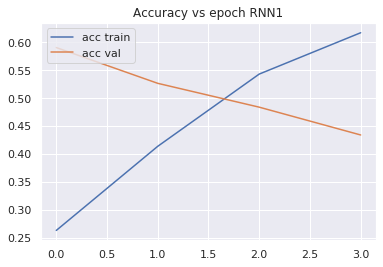


------ Training ------
Accuracy rnn1 : 0.5796452084857352
F1-score None rnn1 : [0.68214286 0.51479568 0.63981781 0.40415977]
F1-score macro rnn1 : 0.5602290300768485

------ Validation ------
Accuracy rnn1 : 0.43416370106761565
F1-score None rnn1 : [0.58503401 0.21052632 0.3537415  0.42608696]
F1-score macro rnn1 : 0.39384719562882364

------ Testing ------
Accuracy rnn1 : 0.3614103819784525
F1-score None rnn1 : [0.25396825 0.2010582  0.31181102 0.44120505]
F1-score macro rnn1 : 0.30201063302461345


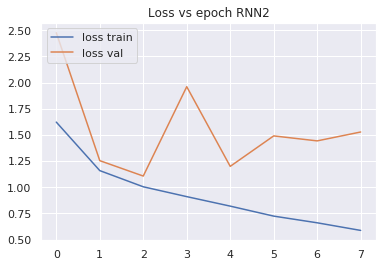

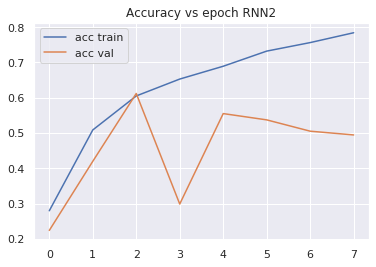


------ Training ------
Accuracy rnn2 : 0.806784930504755
F1-score None rnn2 : [0.74689507 0.86097043 0.90612105 0.68717949]
F1-score macro rnn2 : 0.8002915092965825

------ Validation ------
Accuracy rnn2 : 0.49466192170818507
F1-score None rnn2 : [0.47787611 0.13793103 0.52380952 0.60431655]
F1-score macro rnn2 : 0.4359833028123906

------ Testing ------
Accuracy rnn2 : 0.5386875612144956
F1-score None rnn2 : [0.16528926 0.20578778 0.47826087 0.66925466]
F1-score macro rnn2 : 0.379648141374785


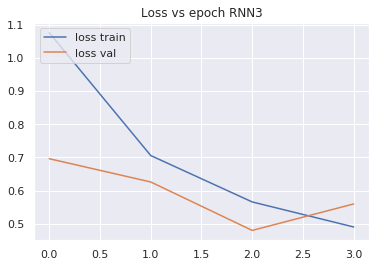

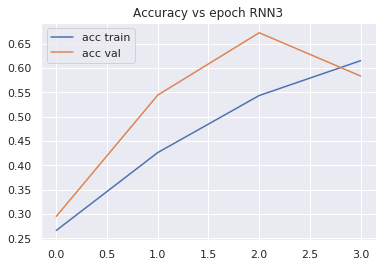


------ Training ------
Accuracy rnn3 : 0.6834308705193856
F1-score None rnn3 : [0.70625875 0.66457582 0.80994358 0.53587723]
F1-score macro rnn3 : 0.6791638448692823

------ Validation ------
Accuracy rnn3 : 0.5836298932384342
F1-score None rnn3 : [0.6122449  0.1971831  0.66666667 0.64705882]
F1-score macro rnn3 : 0.5307883716867028

------ Testing ------
Accuracy rnn3 : 0.4348677766895201
F1-score None rnn3 : [0.24277457 0.20382166 0.53287197 0.5374211 ]
F1-score macro rnn3 : 0.37922232373336356

Entrenando exec  2 



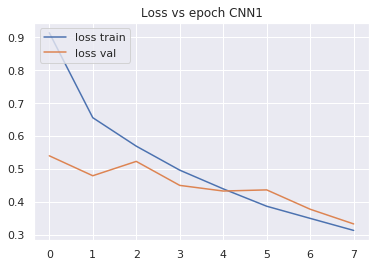

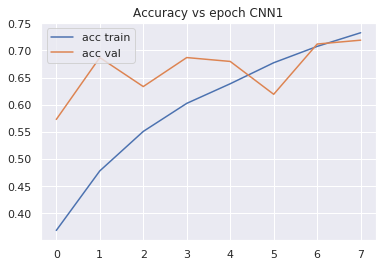


------ Training ------
Accuracy cnn1 : 0.8243416239941478
F1-score None cnn1 : [0.74563107 0.89870731 0.93908087 0.72111801]
F1-score macro cnn1 : 0.8261343155015781

------ Validation ------
Accuracy cnn1 : 0.7188612099644128
F1-score None cnn1 : [0.59541985 0.38095238 0.64615385 0.8       ]
F1-score macro cnn1 : 0.6056315186086179

------ Testing ------
Accuracy cnn1 : 0.722820763956905
F1-score None cnn1 : [0.1        0.22695035 0.6015625  0.82847896]
F1-score macro cnn1 : 0.43924795475280587


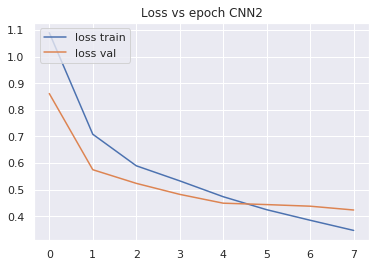

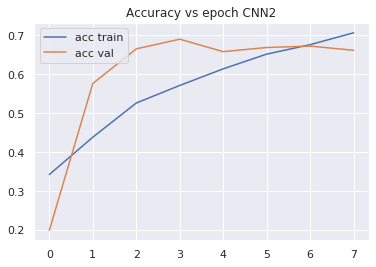


------ Training ------
Accuracy cnn2 : 0.7631675201170446
F1-score None cnn2 : [0.64888248 0.8438715  0.89011725 0.66442953]
F1-score macro cnn2 : 0.7618251897777246

------ Validation ------
Accuracy cnn2 : 0.6619217081850534
F1-score None cnn2 : [0.50943396 0.33333333 0.54945055 0.75504323]
F1-score macro cnn2 : 0.536815268178435

------ Testing ------
Accuracy cnn2 : 0.713026444662096
F1-score None cnn2 : [0.04761905 0.18018018 0.5482866  0.82306684]
F1-score macro cnn2 : 0.399788168394016


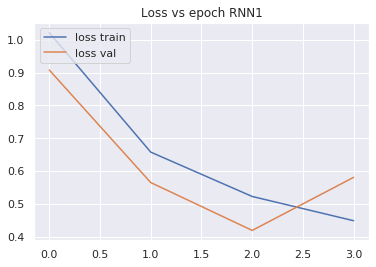

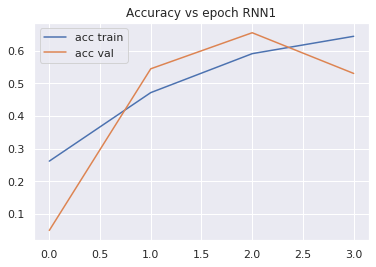


------ Training ------
Accuracy rnn1 : 0.6849853694220922
F1-score None rnn1 : [0.70201835 0.68208092 0.79635915 0.52244566]
F1-score macro rnn1 : 0.675726021275954

------ Validation ------
Accuracy rnn1 : 0.5302491103202847
F1-score None rnn1 : [0.59210526 0.15789474 0.46601942 0.57249071]
F1-score macro rnn1 : 0.4471275309488577

------ Testing ------
Accuracy rnn1 : 0.48677766895200786
F1-score None rnn1 : [0.2745098  0.18623482 0.43520782 0.60406091]
F1-score macro rnn1 : 0.3750033398504494


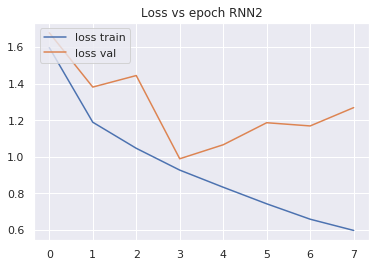

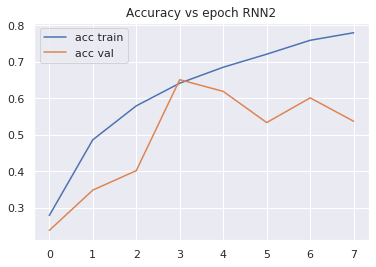


------ Training ------
Accuracy rnn2 : 0.7951719092904169
F1-score None rnn2 : [0.74870242 0.85657634 0.87469207 0.66966908]
F1-score macro rnn2 : 0.7874099774653726

------ Validation ------
Accuracy rnn2 : 0.5373665480427047
F1-score None rnn2 : [0.57142857 0.18461538 0.52272727 0.60777385]
F1-score macro rnn2 : 0.4716362700903337

------ Testing ------
Accuracy rnn2 : 0.5357492654260528
F1-score None rnn2 : [0.12280702 0.22073579 0.4469914  0.6703125 ]
F1-score macro rnn2 : 0.3652116768771245


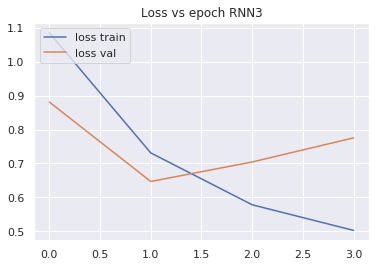

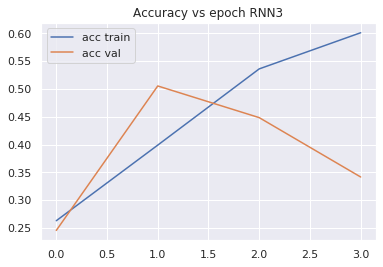


------ Training ------
Accuracy rnn3 : 0.5980248719824433
F1-score None rnn3 : [0.66248235 0.59381997 0.69574496 0.27997738]
F1-score macro rnn3 : 0.5580061651878909

------ Validation ------
Accuracy rnn3 : 0.3416370106761566
F1-score None rnn3 : [0.46067416 0.13333333 0.34666667 0.26470588]
F1-score macro rnn3 : 0.301345009914078

------ Testing ------
Accuracy rnn3 : 0.25269343780607245
F1-score None rnn3 : [0.21148036 0.16326531 0.30491803 0.2519337 ]
F1-score macro rnn3 : 0.23289935077613927

Entrenando exec  3 



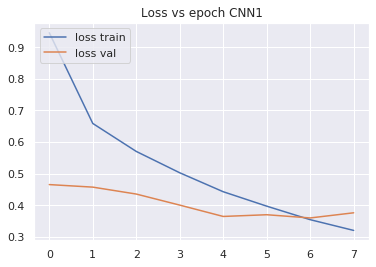

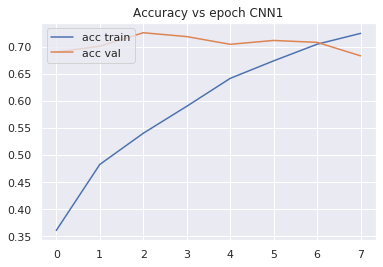


------ Training ------
Accuracy cnn1 : 0.8119970738844184
F1-score None cnn1 : [0.77907364 0.86299406 0.94419971 0.6726846 ]
F1-score macro cnn1 : 0.8147380023924792

------ Validation ------
Accuracy cnn1 : 0.6832740213523132
F1-score None cnn1 : [0.56976744 0.4        0.72727273 0.75      ]
F1-score macro cnn1 : 0.6117600422832981

------ Testing ------
Accuracy cnn1 : 0.6415279138099902
F1-score None cnn1 : [0.20945946 0.23214286 0.62910798 0.76565799]
F1-score macro cnn1 : 0.45909207128895946


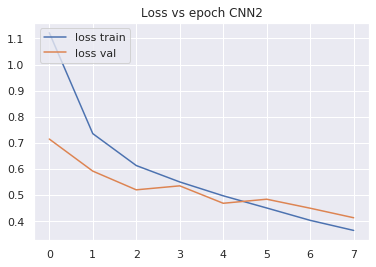

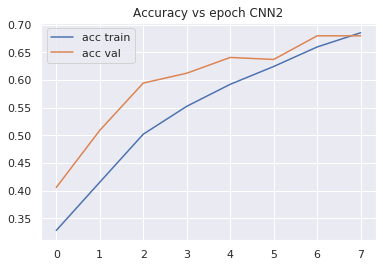


------ Training ------
Accuracy cnn2 : 0.8090709583028529
F1-score None cnn2 : [0.73433748 0.86703097 0.94113411 0.69548511]
F1-score macro cnn2 : 0.8094969175432576

------ Validation ------
Accuracy cnn2 : 0.6797153024911032
F1-score None cnn2 : [0.5        0.2962963  0.65625    0.77183099]
F1-score macro cnn2 : 0.5560943205529474

------ Testing ------
Accuracy cnn2 : 0.6787463271302644
F1-score None cnn2 : [0.1        0.21459227 0.60425532 0.80325645]
F1-score macro cnn2 : 0.4305260097186344


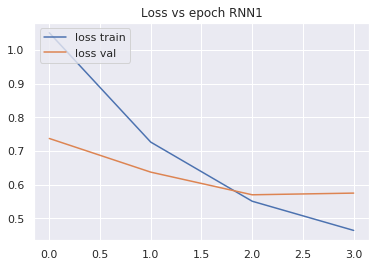

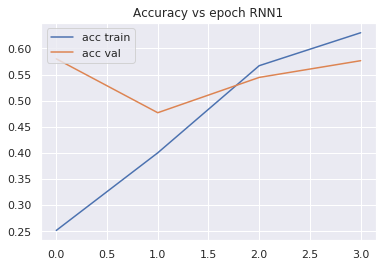


------ Training ------
Accuracy rnn1 : 0.6509692757863935
F1-score None rnn1 : [0.68459225 0.57103193 0.76948491 0.52997327]
F1-score macro rnn1 : 0.6387705903622357

------ Validation ------
Accuracy rnn1 : 0.5765124555160143
F1-score None rnn1 : [0.57324841 0.17391304 0.50505051 0.6360424 ]
F1-score macro rnn1 : 0.4720635897497333

------ Testing ------
Accuracy rnn1 : 0.5053868756121449
F1-score None rnn1 : [0.28070175 0.18181818 0.44180523 0.62023217]
F1-score macro rnn1 : 0.38113933358208296


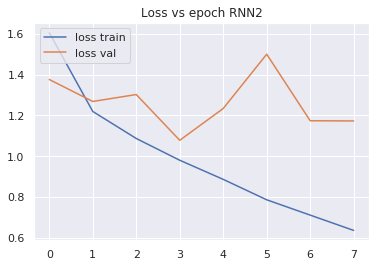

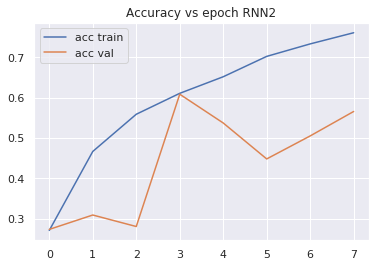


------ Training ------
Accuracy rnn2 : 0.7691111923920995
F1-score None rnn2 : [0.71874515 0.83974234 0.89102313 0.64247312]
F1-score macro rnn2 : 0.7729959329250164

------ Validation ------
Accuracy rnn2 : 0.5658362989323843
F1-score None rnn2 : [0.53684211 0.11764706 0.52830189 0.64561404]
F1-score macro rnn2 : 0.45710127149171487

------ Testing ------
Accuracy rnn2 : 0.5377081292850147
F1-score None rnn2 : [0.21288515 0.22772277 0.5        0.68164214]
F1-score macro rnn2 : 0.40556251605411664


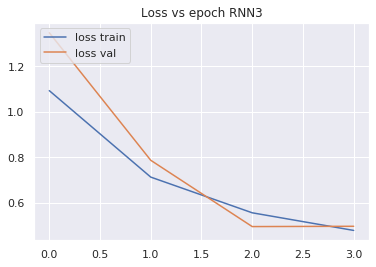

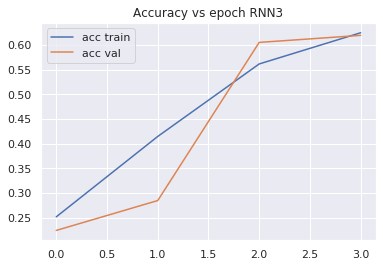


------ Training ------
Accuracy rnn3 : 0.6849853694220922
F1-score None rnn3 : [0.69913175 0.67653531 0.80064137 0.57061389]
F1-score macro rnn3 : 0.6867305777750287

------ Validation ------
Accuracy rnn3 : 0.6192170818505338
F1-score None rnn3 : [0.54545455 0.25       0.66666667 0.69624573]
F1-score macro rnn3 : 0.5395917364774021

------ Testing ------
Accuracy rnn3 : 0.5484818805093046
F1-score None rnn3 : [0.20853081 0.21960784 0.55333333 0.669279  ]
F1-score macro rnn3 : 0.412687744755749

Entrenando exec  4 



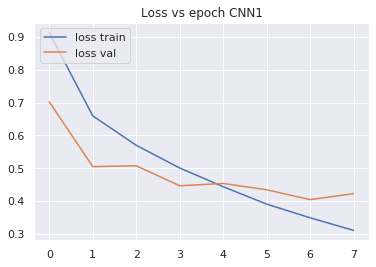

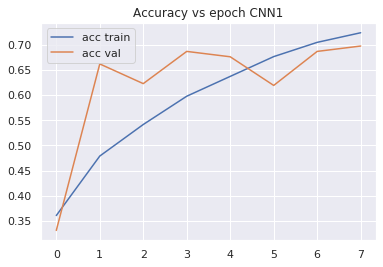


------ Training ------
Accuracy cnn1 : 0.8149231894659839
F1-score None cnn1 : [0.79090909 0.86565945 0.8881957  0.71646917]
F1-score macro cnn1 : 0.8153083540709892

------ Validation ------
Accuracy cnn1 : 0.697508896797153
F1-score None cnn1 : [0.6056338  0.42857143 0.6097561  0.77160494]
F1-score macro cnn1 : 0.6038915668052276

------ Testing ------
Accuracy cnn1 : 0.6679725759059746
F1-score None cnn1 : [0.13235294 0.15053763 0.50574713 0.7890785 ]
F1-score macro cnn1 : 0.3944290500788425


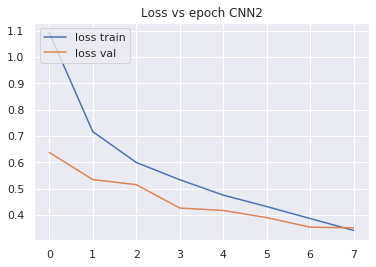

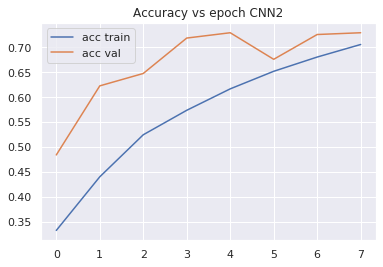


------ Training ------
Accuracy cnn2 : 0.8108083394294074
F1-score None cnn2 : [0.76142943 0.85602953 0.91614692 0.71729686]
F1-score macro cnn2 : 0.8127256845028688

------ Validation ------
Accuracy cnn2 : 0.7295373665480427
F1-score None cnn2 : [0.60431655 0.44444444 0.68656716 0.80473373]
F1-score macro cnn2 : 0.6350154707991975

------ Testing ------
Accuracy cnn2 : 0.6993143976493633
F1-score None cnn2 : [0.17518248 0.18181818 0.57243816 0.81279147]
F1-score macro cnn2 : 0.4355575746164854


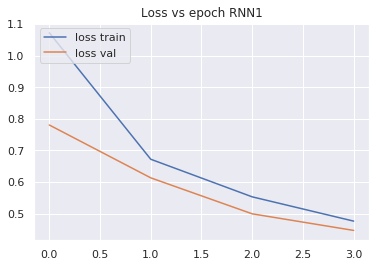

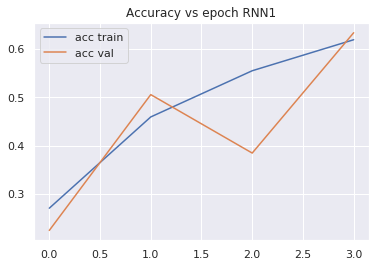


------ Training ------
Accuracy rnn1 : 0.5690380395025604
F1-score None rnn1 : [0.64840881 0.22541507 0.75232707 0.50260223]
F1-score macro rnn1 : 0.5321882951096131

------ Validation ------
Accuracy rnn1 : 0.6334519572953736
F1-score None rnn1 : [0.54761905 0.13333333 0.62337662 0.70860927]
F1-score macro rnn1 : 0.5032345689630457

------ Testing ------
Accuracy rnn1 : 0.6062683643486778
F1-score None rnn1 : [0.21518987 0.06451613 0.6        0.73514307]
F1-score macro rnn1 : 0.4037122673036174


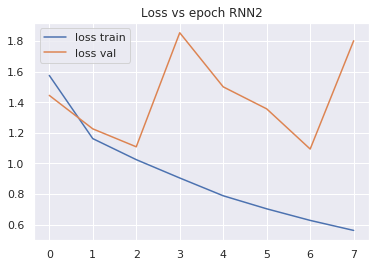

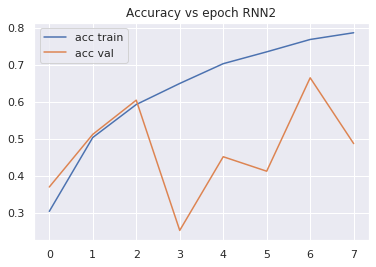


------ Training ------
Accuracy rnn2 : 0.7239392831016825
F1-score None rnn2 : [0.51420912 0.75239167 0.91642979 0.6482543 ]
F1-score macro rnn2 : 0.7078212188512635

------ Validation ------
Accuracy rnn2 : 0.4875444839857651
F1-score None rnn2 : [0.25       0.144      0.55172414 0.68227425]
F1-score macro rnn2 : 0.4069995963556683

------ Testing ------
Accuracy rnn2 : 0.5337904015670911
F1-score None rnn2 : [0.04494382 0.19325843 0.51256281 0.68601986]
F1-score macro rnn2 : 0.3591962309379534


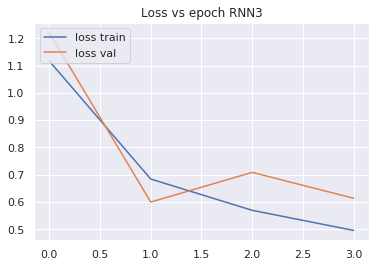

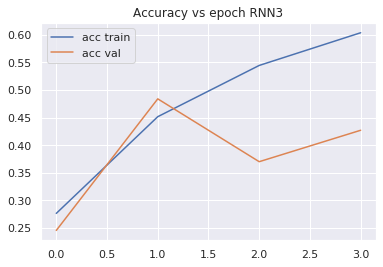


------ Training ------
Accuracy rnn3 : 0.6255486466715435
F1-score None rnn3 : [0.68183601 0.60167131 0.7729207  0.41180812]
F1-score macro rnn3 : 0.6170590344303797

------ Validation ------
Accuracy rnn3 : 0.42704626334519574
F1-score None rnn3 : [0.55782313 0.08849558 0.65671642 0.44255319]
F1-score macro rnn3 : 0.43639707846818726

------ Testing ------
Accuracy rnn3 : 0.3545543584720862
F1-score None rnn3 : [0.13095238 0.17537943 0.5877551  0.43822394]
F1-score macro rnn3 : 0.3330777119653294

Entrenando exec  5 



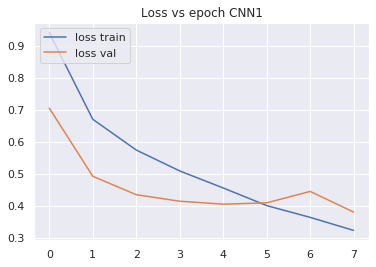

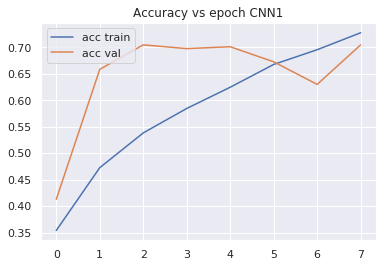


------ Training ------
Accuracy cnn1 : 0.8049561082662765
F1-score None cnn1 : [0.71814327 0.89388826 0.90713418 0.69790343]
F1-score macro cnn1 : 0.8042672861004825

------ Validation ------
Accuracy cnn1 : 0.7046263345195729
F1-score None cnn1 : [0.60162602 0.4137931  0.64102564 0.78313253]
F1-score macro cnn1 : 0.6098943227136404

------ Testing ------
Accuracy cnn1 : 0.693437806072478
F1-score None cnn1 : [0.11538462 0.2745098  0.54666667 0.80673401]
F1-score macro cnn1 : 0.4358237731767144


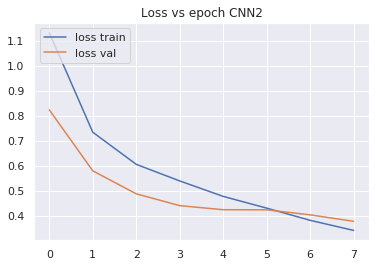

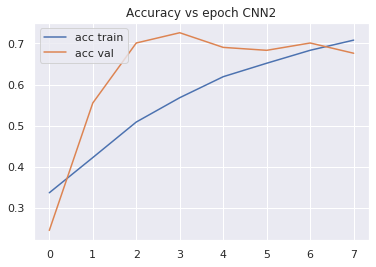


------ Training ------
Accuracy cnn2 : 0.7350950987564009
F1-score None cnn2 : [0.76094276 0.61089987 0.89502762 0.64376513]
F1-score macro cnn2 : 0.7276588479203384

------ Validation ------
Accuracy cnn2 : 0.6761565836298933
F1-score None cnn2 : [0.59060403 0.         0.58666667 0.75840979]
F1-score macro cnn2 : 0.4839201198612566

------ Testing ------
Accuracy cnn2 : 0.6807051909892262
F1-score None cnn2 : [0.15189873 0.1        0.53074434 0.79866221]
F1-score macro cnn2 : 0.3953263195261635


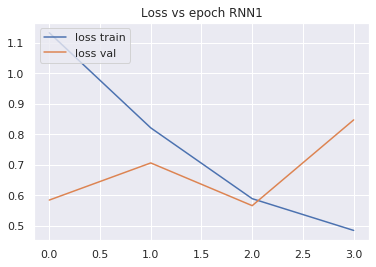

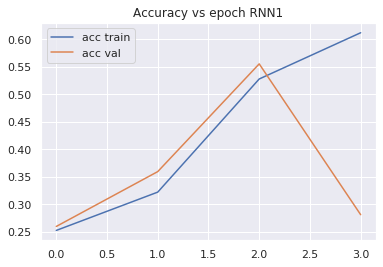


------ Training ------
Accuracy rnn1 : 0.5098756400877835
F1-score None rnn1 : [0.59479214 0.52263541 0.56013746 0.31044268]
F1-score macro rnn1 : 0.49700192164884643

------ Validation ------
Accuracy rnn1 : 0.28113879003558717
F1-score None rnn1 : [0.38095238 0.0952381  0.52830189 0.33488372]
F1-score macro rnn1 : 0.33484402097829036

------ Testing ------
Accuracy rnn1 : 0.23702252693437806
F1-score None rnn1 : [0.07751938 0.15346535 0.45303867 0.29004329]
F1-score macro rnn1 : 0.2435166726140135


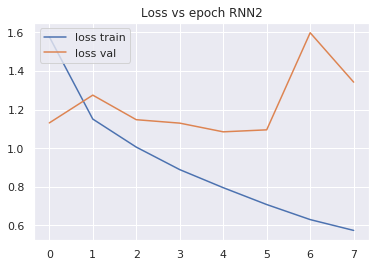

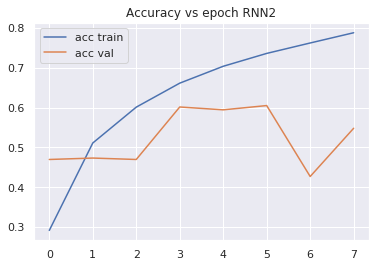


------ Training ------
Accuracy rnn2 : 0.8308339429407462
F1-score None rnn2 : [0.77180114 0.88397026 0.93345102 0.72226251]
F1-score macro rnn2 : 0.8278712306787464

------ Validation ------
Accuracy rnn2 : 0.5480427046263345
F1-score None rnn2 : [0.49612403 0.11940299 0.52777778 0.67346939]
F1-score macro rnn2 : 0.4541935454038146

------ Testing ------
Accuracy rnn2 : 0.5778648383937316
F1-score None rnn2 : [0.11688312 0.20849421 0.51957295 0.71364985]
F1-score macro rnn2 : 0.38965003268650694


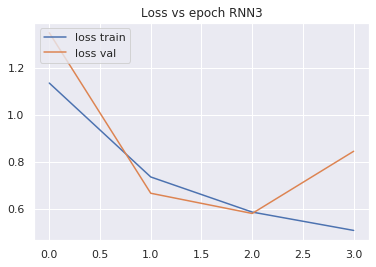

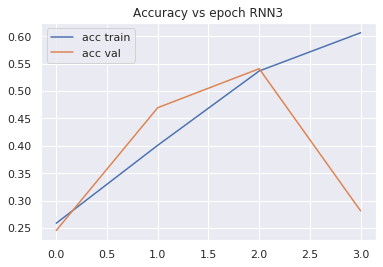


------ Training ------
Accuracy rnn3 : 0.5591623994147769
F1-score None rnn3 : [0.68780126 0.53997227 0.72347399 0.10680272]
F1-score macro rnn3 : 0.5145125603467945

------ Validation ------
Accuracy rnn3 : 0.28113879003558717
F1-score None rnn3 : [0.55345912 0.09090909 0.58461538 0.09782609]
F1-score macro rnn3 : 0.3317024204944632

------ Testing ------
Accuracy rnn3 : 0.16552399608227228
F1-score None rnn3 : [0.16309013 0.16030534 0.56074766 0.06674907]
F1-score macro rnn3 : 0.23772305218693993


In [27]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn1_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN1")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/cnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch CNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch CNN2")
    plt.show()
    
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn1_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN1")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN1")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=8, BS=32, verb=0, focal=False)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn2_'+str(i)+'-exec_15.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN2")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN2")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    #trained.save('../new_glove_augmented/harassment_baselines/0.0/rnn3_'+str(i)+'-exec_8.h5')
    plt.plot(hist.history['loss'], label='loss train')
    plt.plot(hist.history['val_loss'],label='loss val')
    plt.legend(loc='upper left')
    plt.title("Loss vs epoch RNN3")
    plt.show()

    plt.plot(hist.history['acc'], label='acc train')
    plt.plot(hist.history['val_acc'],label='acc val')
    plt.legend(loc='upper left')
    plt.title("Accuracy vs epoch RNN3")
    plt.show()
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


In [28]:
print ("--------- Usando contexto positivo obligadamente y negativo cuando es posible ---------\n")

for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.15 Clase Ponderado - F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.15 Clase Ponderado - F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.15 Clase Ponderado - Accuracy promedio para",key,":" ,temp/5)

--------- Usando contexto positivo obligadamente y negativo cuando es posible ---------

0.15 Clase Ponderado - F1-score promedio para cnn1 : [0.12244858 0.21087068 0.58228057 0.80452884]
0.15 Clase Ponderado - F1-score promedio para cnn2 : [0.11808055 0.16865146 0.5719292  0.81133288]
0.15 Clase Ponderado - F1-score promedio para rnn1 : [0.22037781 0.15741854 0.44837255 0.5381369 ]
0.15 Clase Ponderado - F1-score promedio para rnn2 : [0.13256167 0.2111998  0.49147761 0.6841758 ]
0.15 Clase Ponderado - F1-score promedio para rnn3 : [0.19136565 0.18447592 0.50792522 0.39272136]

0.15 Clase Ponderado - F1-score macro promedio para cnn1 : 0.4300321691253206 desvest:  0.021457751992876892
0.15 Clase Ponderado - F1-score macro promedio para cnn2 : 0.4174985227570934 desvest:  0.01660408362198312
0.15 Clase Ponderado - F1-score macro promedio para rnn1 : 0.34107644927495534 desvest:  0.05953715197200121
0.15 Clase Ponderado - F1-score macro promedio para rnn2 : 0.3798537195860973 desvest:  0